<a target="_blank" href="https://colab.research.google.com/github/sky1ove/katlas/blob/main/nbs/tutorial_04b_enrichment_EGFRi.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Kinase enrichment analysis - EGFRi

In this session, we will analyze the differential change of phosphorylation sites in phosphoproteomics dataset.

## Setup

In [ ]:
!pip install git+https://github.com/sky1ove/katlas.git -q

In [ ]:
# katlas
from katlas.core import *
from katlas.plot import plot_rank, set_sns

# utils
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce, partial
from tqdm import tqdm

# statistics
from scipy.stats import ttest_rel,ttest_ind
from statsmodels.stats.multitest import multipletests

# disable warning
import warnings
warnings.filterwarnings("ignore", message="converting a masked element to nan")

pd.set_option('display.precision', 15)

set_sns()

## Data

The phosphoproteomics dataset of EGFR inhibitor is from paper [Phosphoproteome Profiling Reveals Molecular Mechanisms of Growth-Factor-Mediated Kinase Inhibitor Resistance in EGFR-Overexpressing Cancer Cells](https://pubs.acs.org/doi/10.1021/acs.jproteome.6b00621).

<img src="https://github.com/sky1ove/katlas/raw/main/dataset/images/EGFRi.png"/>

In [ ]:
df = pd.read_csv('https://github.com/sky1ove/katlas/raw/main/nbs/raw/EGFRi.csv')

In [ ]:
df = df.dropna(subset='sequence').reset_index(drop=True)

In [ ]:
site_seq= extract_site_seq(df,'sequence','Predicted modification site')

100%|██████████| 15297/15297 [00:00<00:00, 28189.32it/s]


In [ ]:
df['site_seq'] = site_seq

In [ ]:
df['acceptor'] = df.site_seq.str[7]

In [ ]:
df = df[df.acceptor.isin(['S','T','Y'])].reset_index(drop=True)

In [ ]:
df['gene_site'] = df['Gene names']+'_'+df['Amino acid']+df['Predicted modification site'].astype(str)

In [ ]:
df.head()

,Uniprot accession number,Gene names,sequence,Predicted modification site,Amino acid,DMSO log2 intensity 1,DMSO log2 intensity 2,DMSO log2 intensity 3,Gefitinib log2 intensity 1,Gefitinib log2 intensity 2,Gefitinib log2 intensity 3,Gefitinib+FGF2 log2 intensity 1,Gefitinib+FGF2 log2 intensity 2,Gefitinib+GF2 log2 intensity 3,site_seq,acceptor,gene_site
0,B0FLL2,PFKFB2,MTNSPTLIVMIGLPARGKTYVSKKLTRYLNWIGVPTKVFNLGVYRREAVKSYKSYDFFRHDNEEAMKIRKQCALVALEDVKAYLTEENGQIAVFDATNTTRERRDMILNFAEQNSFKVFFVESVCDDPDVIAANILEVKVSSPDYPERNRENVMEDFLKRIECYKVTYRPLDPDNYDKDLSFIKVINVGQRFLVNRVQDYIQSKIVYYLMNIHVQPRTIYLCRHGESEFNLLGKIGGDSGLSVRGKQFAQALRKFLEEQEITDLKVWTSQLKRTIQTAESLGVPYEQWKILNEIDAGVCEEMTYAEIEKRYPEEFALRDQEKYLYRYPGGESYQDLVQRLEPVIMELERQGNVLVISHQAVMRCLLAYFLDKGADELPYLRCPLHTIFKLTPVAYGCKVETIKLNVEAVNTHRDKPTNNFPKNQTPVRMRRNSFTPLSSSNTIRRPRNYSVGSRPLKPLSPLRAQDMQEGAD,460,S,18.304400000000001,18.229900000000001,18.157699999999998,17.826300000000000,17.811699999999998,17.818500000000000,17.606300000000001,17.691199999999998,17.658799999999999,SRPLKPLSPLRAQDM,S,PFKFB2_S460
1,Q96QC0,PPP1R10,MGSGPIDPKELLKGLDSFLNRDGEVKSVDGISKIFSLMKEARKMVSRCTYLNILLQTRSPEILVKFIDVGGYKLLNNWLTYSKTTNNIPLLQQILLTLQHLPLTVDHLKQNNTAKLVKQLSKSSEDEELRKLASVLVSDWMAVIRSQSSTQPAEKDKKKRKDEGKSRTTLPERPLTEVKAETRAEEAPEKKREKPKSLRTTAPSHAKFRSTGLELETPSLVPVKKNASTVVVSDKYNLKPIPLKRQSNVAAPGDATPPAEKKYKPLNTTPNATKEIKVKIIPPQPMEGLGFLDALNSAPVPGIKIKKKKKVLSPTAAKPSPFEGKTSTEPSTAKPSSPEPAPPSEAMDADRPGTPVPPVEVPELMDTASLEPGALDAKPVESPGDPNQLTRKGRKRKSVTWPEEGKLREYFYFELDETERVNVNKIKDFGEAAKREILSDRHAFETARRLSHDNMEEKVPWVCPRPLVLPSPLVTPGSNSQERYIQAEREKGILQELFLNKESPHEPDPEPYEPIPPKLIPLDEECSMDETPYVETLEPGGSGGSPDGAGGSKLPPVLANLMGSMGAGKGPQGPGGGGINVQEILTSIMGSPNSHP...,256,T,19.686299999999999,19.683700000000002,19.718499999999999,19.492000000000001,19.440600000000000,19.514099999999999,19.541399999999999,19.555099999999999,19.487300000000001,VAAPGDATPPAEKKY,T,PPP1R10_T256
2,Q12923-3,PTPN13,MHVSLAEALEVRGGPLQEEEIWAVLNQSAESLQELFRKVSLADPAALGFIISPWSLLLLPSGSVSFTDENISNQDLRAFTAPEVLQNQSLTSLSDVEKIHIYSLGMTLYWGADYEVPQSQPIKLGDHLNSILLGMCEDVIYARVSVRTVLDACSAHIRNSNCAPSFSYVKHLVKLVLGNLSGTDQLSCNSEQKPDRSQAIRDRLRGKGLPTGRSSTSDVLDIQKPPLSHQTFLNKGLSKSMGFLSIKDTQDENYFKDILSDNSGREDSENTFSPYQFKTSGPEKKPIPGIDVLSKKKIWASSMDLLCTADRDFSSGETATYRRCHPEAVTVRTSTTPRKKEARYSDGSIALDIFGPQKMDPIYHTRELPTSSAISSALDRIRERQKKLQVLREAMNVEEPVRRYKTYHGDVFSTSSESPSIISSESDFRQVRRSEASKRFESSSGLPGVDETLSQGQSQRPSRQYETPFEGNLINQEIMLKRQEEELMQLQAKMALRQSRLSLYPGDTIKASMLDITRDPLREIALETAMTQRKLRNFFGPEFVKMTIEPFISLDLPRSILTKKGKNEDNRRKVNIMLLNGQRLELTCDTKTICKD...,1033,S,17.301100000000002,17.316500000000001,17.312000000000001,17.182099999999998,17.179600000000001,17.155000000000001,17.186699999999998,17.226800000000001,17.205900000000000,SVASLNRSPERRKHE,S,PTPN13_S1033
3,F8W9A8,PPIP5K1,MWSLTASEGESTTAHFFLGAGDEGLGTRGIGMRPEESDSELLEDEEDEVPPEPQIIVGICAMTKKSKSKPMTQILERLCRFDYLTVVILGEDVILNEPVENWPSCHCLISFHSKGFPLDKAVAYSKLRNPFLINDLAMQYYIQDRREVYRILQEEGIDLPRYAVLNRDPARPEECNLIEGEDQVEVNGAVFPKPFVEKPVSAEDHNVYIYYPSSAGGGSQRLFRKIGSRSSVYSPESSVRKTGSYIYEEFMPTDGTDVKVYTVGPDYAHAEARKSPALDGKVERDSEGKEIRYPVMLTAMEKLVARKVCVAFKQTVCGFDLLRANGHSFVCDVNGFSFVKNSMKYYDDCAKILGNTIMRELAPQFQIPWSIPTEAEDIPIVPTTSGTMMELRCVIAIIRHGDRTPKQKMKMEVKHPRFFALFEKHGGYKTGKLKLKRPEQLQEVLDITRLLLAELEKEPGGEIEEKTGKLEQLKSVLEMYGHFSGINRKVQLTYYPHGVKASNEGQDPQRETLAPSLLLVLKWGGELTPAGRVQAEELGRAFRCMYPGGQGDYAGFPGCGLLRLHSTFRHDLKIYASDEGRVQMTAAAFAKGLLAL...,1128,S,16.545200000000001,16.615700000000000,16.563700000000001,16.422499999999999,16.466799999999999,16.446800000000000,16.422899999999998,16.486799999999999,16.445300000000000,SPPRTLHSPPLQLQQ,S,PPIP5K1_S1128
4,B0FLL2,PFKFB2,MTNSPTLIVMIGLPARGKTYVSKKLTRYLNWIGVPTKVFNLGVYRREAVKSYKSYDFFRHDNEEAMKIRKQCALVALEDVKAYLTEENGQIAVFDATNTTRERRDMILNFAEQNSFKVFFVESVCDDPDVIAANILEVKVSSPDYPERNRENVMEDFLKRIECYKVTYRPLDPDNYDKDLSFIKVINVGQRFLVNRVQDYIQSKIVYYLMNIHVQPRTIYLCRHGESEFNLLGKIGGDSGLSVRGKQFAQALRKFLEEQEITDLKVWTSQLKRTIQTAESLGVPYEQWKILNEIDAGVCEEMTYAEIEKRYPEEFALRDQEKYLYRYPGGESYQDLVQRLEPVIMELERQGNVLVISHQAVMRCLLAYFLDKGADELPYLRCPLHTIFKLTPVAYGCKVETIKLNVEAVNTHRDKPTNNFPKNQTPVRMRRNSFTPLSSSNTIRRPRNYSVGSR

In [ ]:
ctrl = df.columns[df.columns.str.contains('DMSO')]

Gefitinib = df.columns[df.columns.str.contains('Gefitinib ')]

rescue = df.columns[df.columns.str.contains('GF2')] #FGF2

## T-test

In [ ]:
gef = get_ttest(df,ctrl, Gefitinib)
res = get_ttest(df,ctrl, rescue)

Computing t-tests: 100%|██████████| 12862/12862 [00:02<00:00, 6122.26it/s]


In [ ]:
info = df[['gene_site','Gene names','site_seq','acceptor']]

gef = pd.concat([info,gef],axis=1)
res = pd.concat([info,res],axis=1)

In [ ]:
gef.sort_values('signed_logP')

,gene_site,Gene names,site_seq,acceptor,log2FC,p_value,p_adj,significant,signed_logP,signed_logPadj
12460,NOC2L_S60,NOC2L,PGGSPSASRRKGRAS,S,-0.525127980000001,0.000000263649841,0.000835407084385,True,-6.578972485813409,-3.078101846168977
2113,RANBP2;RGPD4;RGPD3;RGPD8;RGPD5_S2251,RANBP2;RGPD4;RGPD3;RGPD8;RGPD5,HASPLASSPVRKNLF,S,-0.584800000000001,0.000000389709416,0.000835407084385,True,-6.409259101032082,-3.078101846168977
1607,ZNF318_S173,ZNF318,RLSDRLGSPVDNLED,S,-0.540900000000001,0.000001214018730,0.001419518991476,True,-5.915774612844061,-2.847858792755536
1390,NSRP1_S248,NSRP1,EENPDADSDFDAKSS,S,-0.359900000000000,0.000001923390645,0.001519656846364,True,-5.715932500697213,-2.818254468999652
96,EEF2_T435,EEF2,RIMGPNYTPGKKEDL,T,-0.431299999999997,0.000002000894940,0.001519656846364,True,-5.698775714055953,-2.818254468999652
...,...,...,...,...,...,...,...,...,...,...
3866,NEXN_S179,NEXN,TVVPVKSYKTSGKMK,Y,1.725600000000000,0.000000522210339,0.000959524197941,True,6.282154533686167,3.017944068453674
4204,RTKN2_S202,RTKN2,KKLKTSISKATGKKI,S,1.178699999999999,0.000000346695002,0.000835407084385,True,6.460052419110210,3.078101846168977
4083,MISP_S178,MISP,RTPGPPRSTPLEENV,S,1.465700000000000,0.000000208497362,0.000835407084385,True,6.680899435563339,3.078101846168977
2946,HELZ_S1127,HELZ,STNKQQQSPPKGKSL,S,0.216100000000001,0.000000172101938,0.000835407084385,True,6.764214238935609,3.078101846168977


## Substrate scoring

In [ ]:
pspa_out = predict_kinase_df(gef,seq_col='site_seq', **param_PSPA)
cddm_out = predict_kinase_df(gef,seq_col='site_seq', **param_CDDM_upper) # sequence here are all in upper case

input dataframe has a length 12862
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


100%|██████████| 396/396 [00:22<00:00, 17.57it/s]


input dataframe has a length 12862
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:06<00:00, 43.82it/s]


## Kinase enrichment

In [ ]:
def get_enrichment(score_df, # output df of predict_kinase_df
               site_df, # df that contains site sequence
               signed_p_col, # column of p value to determine significant
               is_Y=False, # whether or not it is Y site or S/T site
               top_n = 5, # top n kinase to consider for each site
               signed_p_thr=1.3, # threshold for p value, default is 1.3 for -log10(0.05)=1.3
              ):

    "Calculate kinase enrichment score for sites with signed log10(p) that pass a threshold(1.3) "
    if is_Y:
        idx_up = site_df.index[(site_df.acceptor.str.upper()=="Y") & (site_df[signed_p_col]>= signed_p_thr)]
        idx_dn = site_df.index[(site_df.acceptor.str.upper()=="Y") & (site_df[signed_p_col]<= -signed_p_thr)]
    else:
        idx_up = site_df.index[(site_df.acceptor.str.upper()!="Y") & (site_df[signed_p_col]>= signed_p_thr)]
        idx_dn = site_df.index[(site_df.acceptor.str.upper()!="Y") & (site_df[signed_p_col]<= -signed_p_thr)]
    
    up_site = site_df.loc[idx_up]
    dn_site = site_df.loc[idx_dn]

    up_score = score_df.loc[idx_up]
    dn_score = score_df.loc[idx_dn]
    
    def top_kinases(site_row,top_n=5):
        # Sort the row in descending order and get the top n kinases
        top_kinases = site_row.sort_values(ascending=False).head(top_n)

        # Get the counts of the top kinases
        kinase_counts = top_kinases.index.value_counts()

        return kinase_counts
    
    func = partial(top_kinases,top_n=top_n)
    
    up_cnt = up_score.apply(func,axis=1)
    dn_cnt = dn_score.apply(func,axis=1)
    
    df_up_cnt = up_cnt.sum().reset_index(name = 'up_cnt')
    df_dn_cnt = dn_cnt.sum().reset_index(name = 'dn_cnt')
    
    df_w_up = up_cnt.multiply(abs(up_site[signed_p_col]),axis=0).sum().reset_index(name = 'up_weighted_cnt')
    df_w_dn = dn_cnt.multiply(abs(dn_site[signed_p_col]),axis=0).sum().reset_index(name = 'dn_weighted_cnt')
    
    dfs = [df_up_cnt,df_dn_cnt,df_w_up,df_w_dn]
    
    result = reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs)
    
    result = result.fillna(0)
    result['enrich'] = result.apply(lambda r: r.up_weighted_cnt if r.up_weighted_cnt >= r.dn_weighted_cnt else -r.dn_weighted_cnt,axis=1)
    result['delta'] = result.up_weighted_cnt - result.dn_weighted_cnt
    result = result.rename(columns={'index':'kinase'})
    
    return result

In [ ]:
st_cddm = get_enrichment(cddm_out,gef,'signed_logPadj',is_Y=False,top_n=10)
st_pspa = get_enrichment(pspa_out,gef,'signed_logPadj',is_Y=False,top_n=10)

In [ ]:
y_cddm = get_enrichment(cddm_out,gef,'signed_logPadj',is_Y=True,top_n=10)
y_pspa = get_enrichment(pspa_out,gef,'signed_logPadj',is_Y=True,top_n=10)

In [ ]:
y_cddm.sort_values('enrich')

,kinase,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,delta
11,EGFR,9.0,20.0,17.511497836318696,36.256709596139359,-36.256709596139359,-18.745211759820663
40,KIT,5.0,18.0,10.197591225550937,31.186780322556700,-31.186780322556700,-20.989189097005763
14,EPHA4,10.0,15.0,21.553767814177263,26.964357667273244,-26.964357667273244,-5.410589853095981
39,JAK3,7.0,15.0,14.744489924016644,26.479434960445154,-26.479434960445154,-11.734945036428510
64,ZAP70,13.0,14.0,24.624473347479650,25.316567829174865,-25.316567829174865,-0.692094481695214
...,...,...,...,...,...,...,...
44,MERTK,6.0,5.0,13.884293121516571,9.876477240581046,13.884293121516571,4.007815880935524
17,EPHA7,7.0,4.0,14.490587625735378,7.768100999658490,14.490587625735378,6.722486626076888
27,FES,8.0,2.0,16.969628366404368,3.773167699296470,16.969628366404368,13.196460667107898
13,EPHA2,9.0,6.0,18.298323199458842,10.224526082056681,18.298323199458842,8.073797117402162


### Enrich

In [ ]:
set_sns()

"enrich" is the bigger value among up_weighted_cnt and dn_weighted_cnt

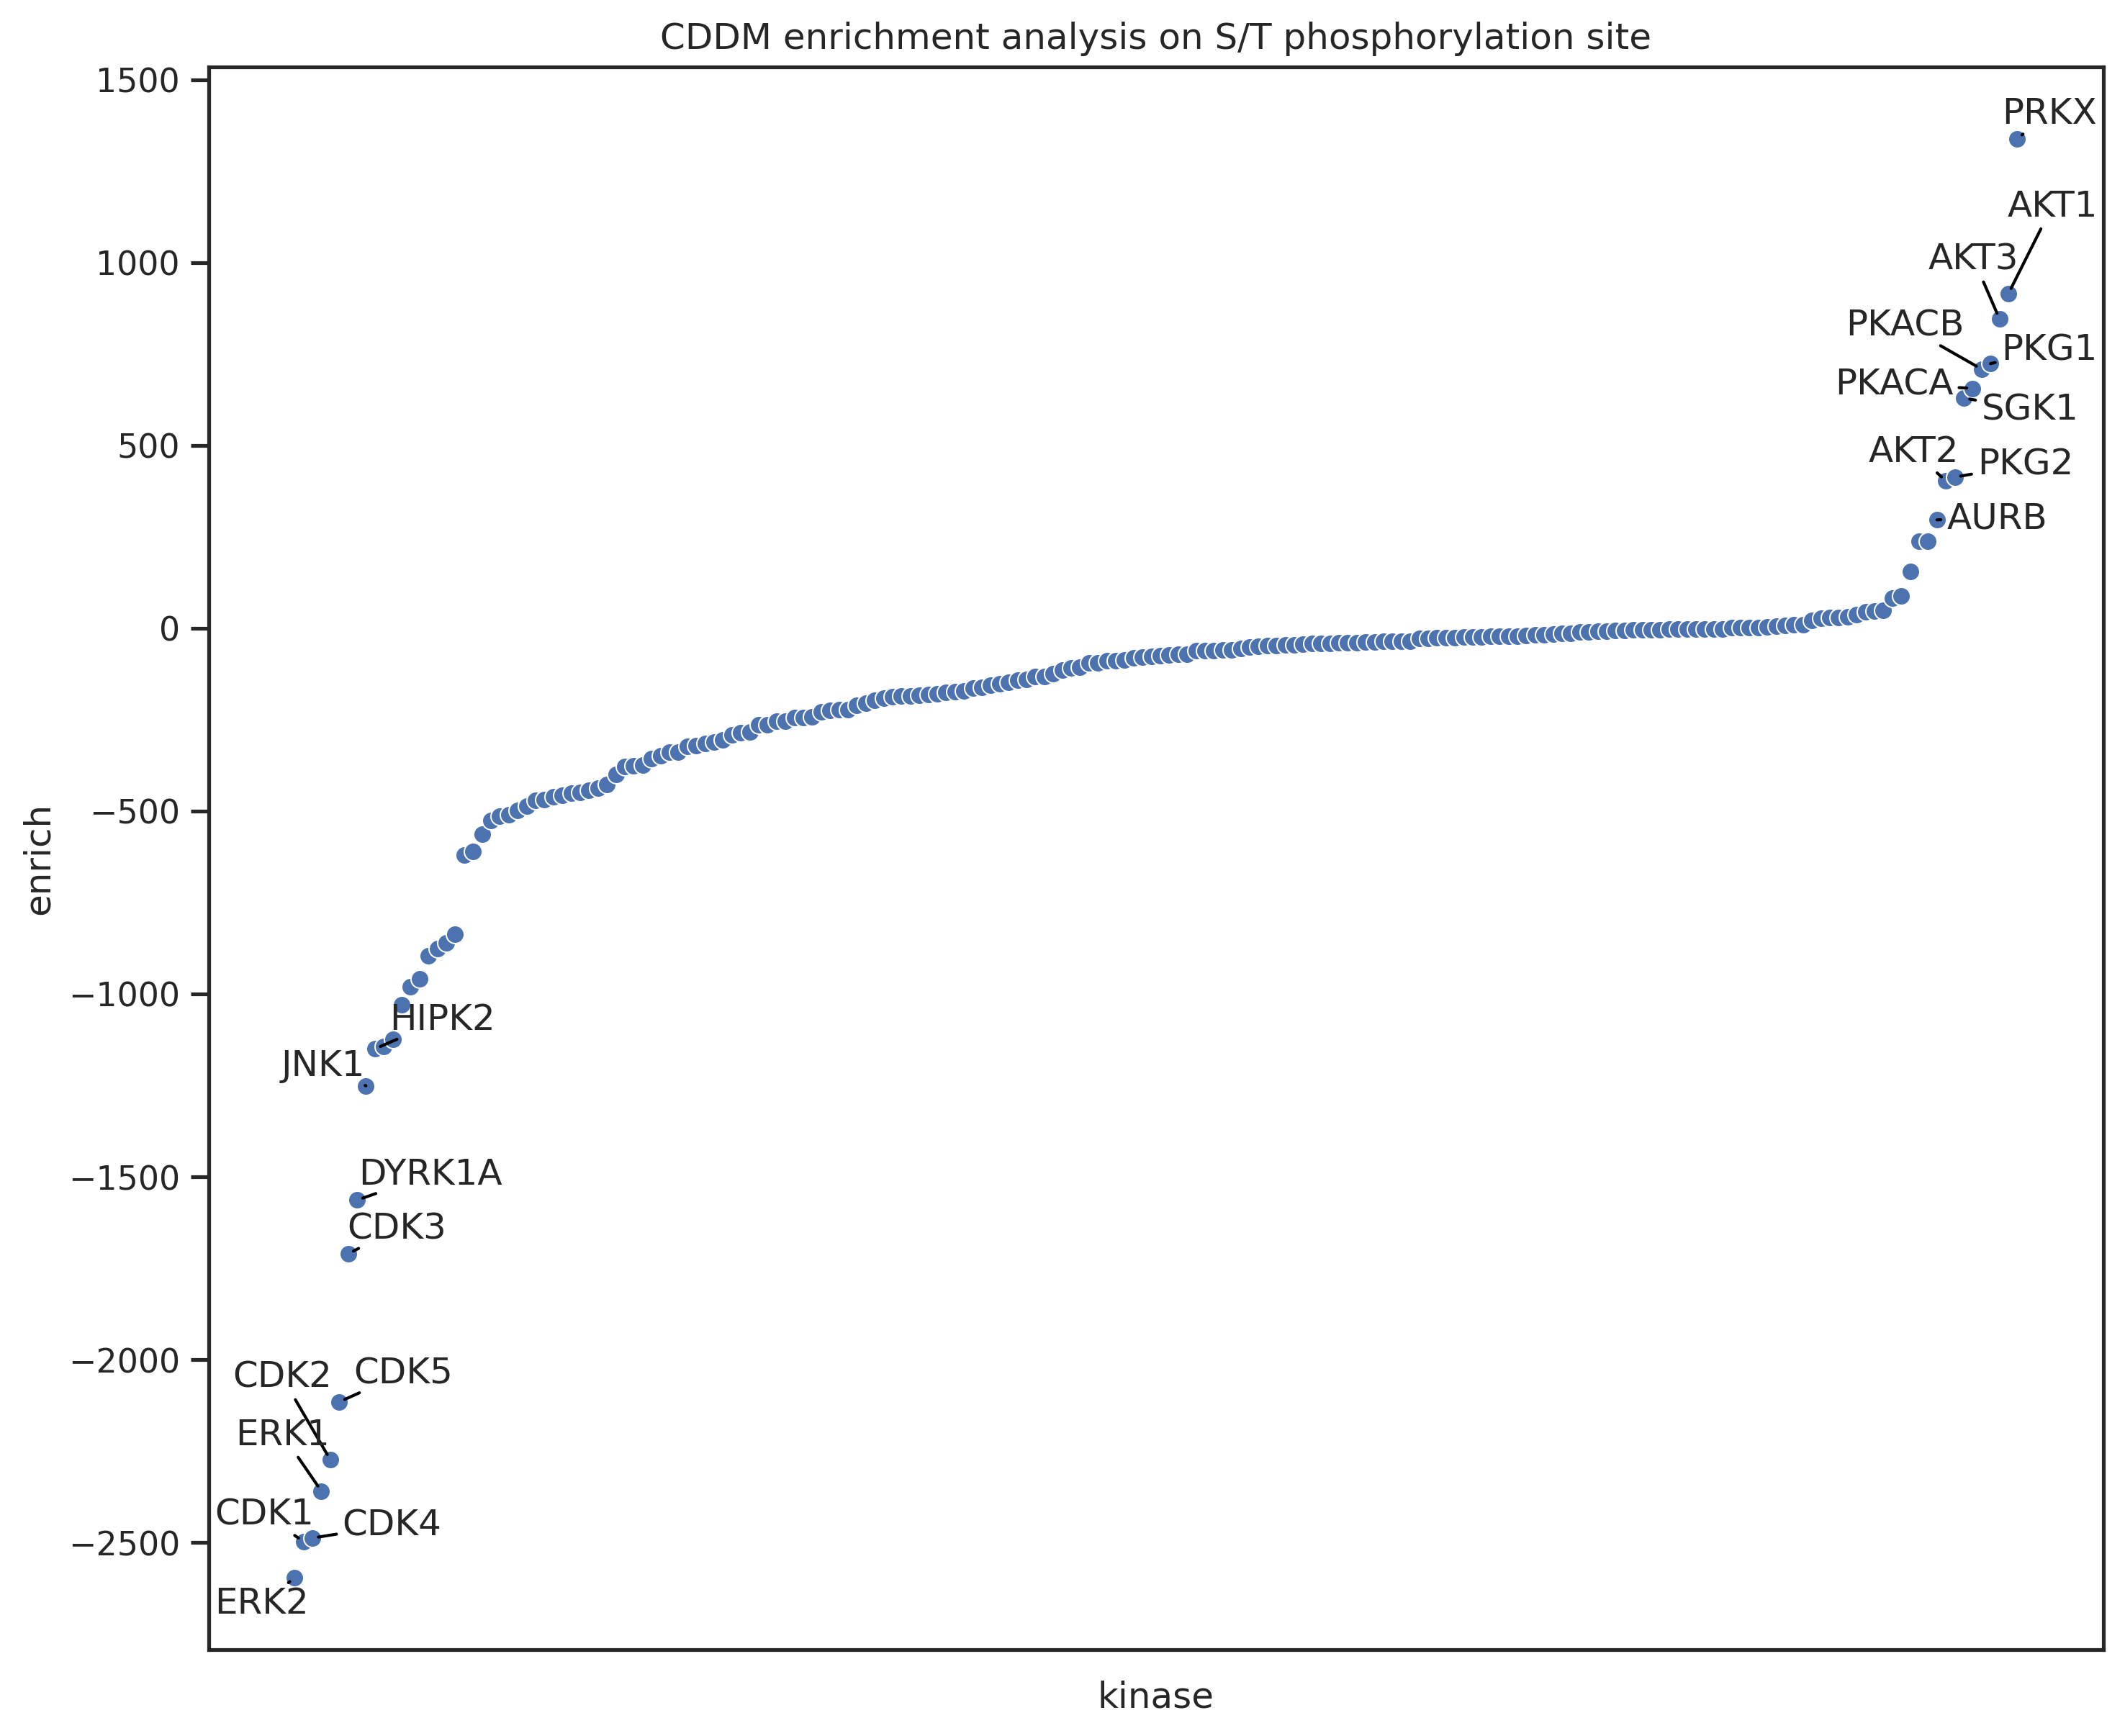

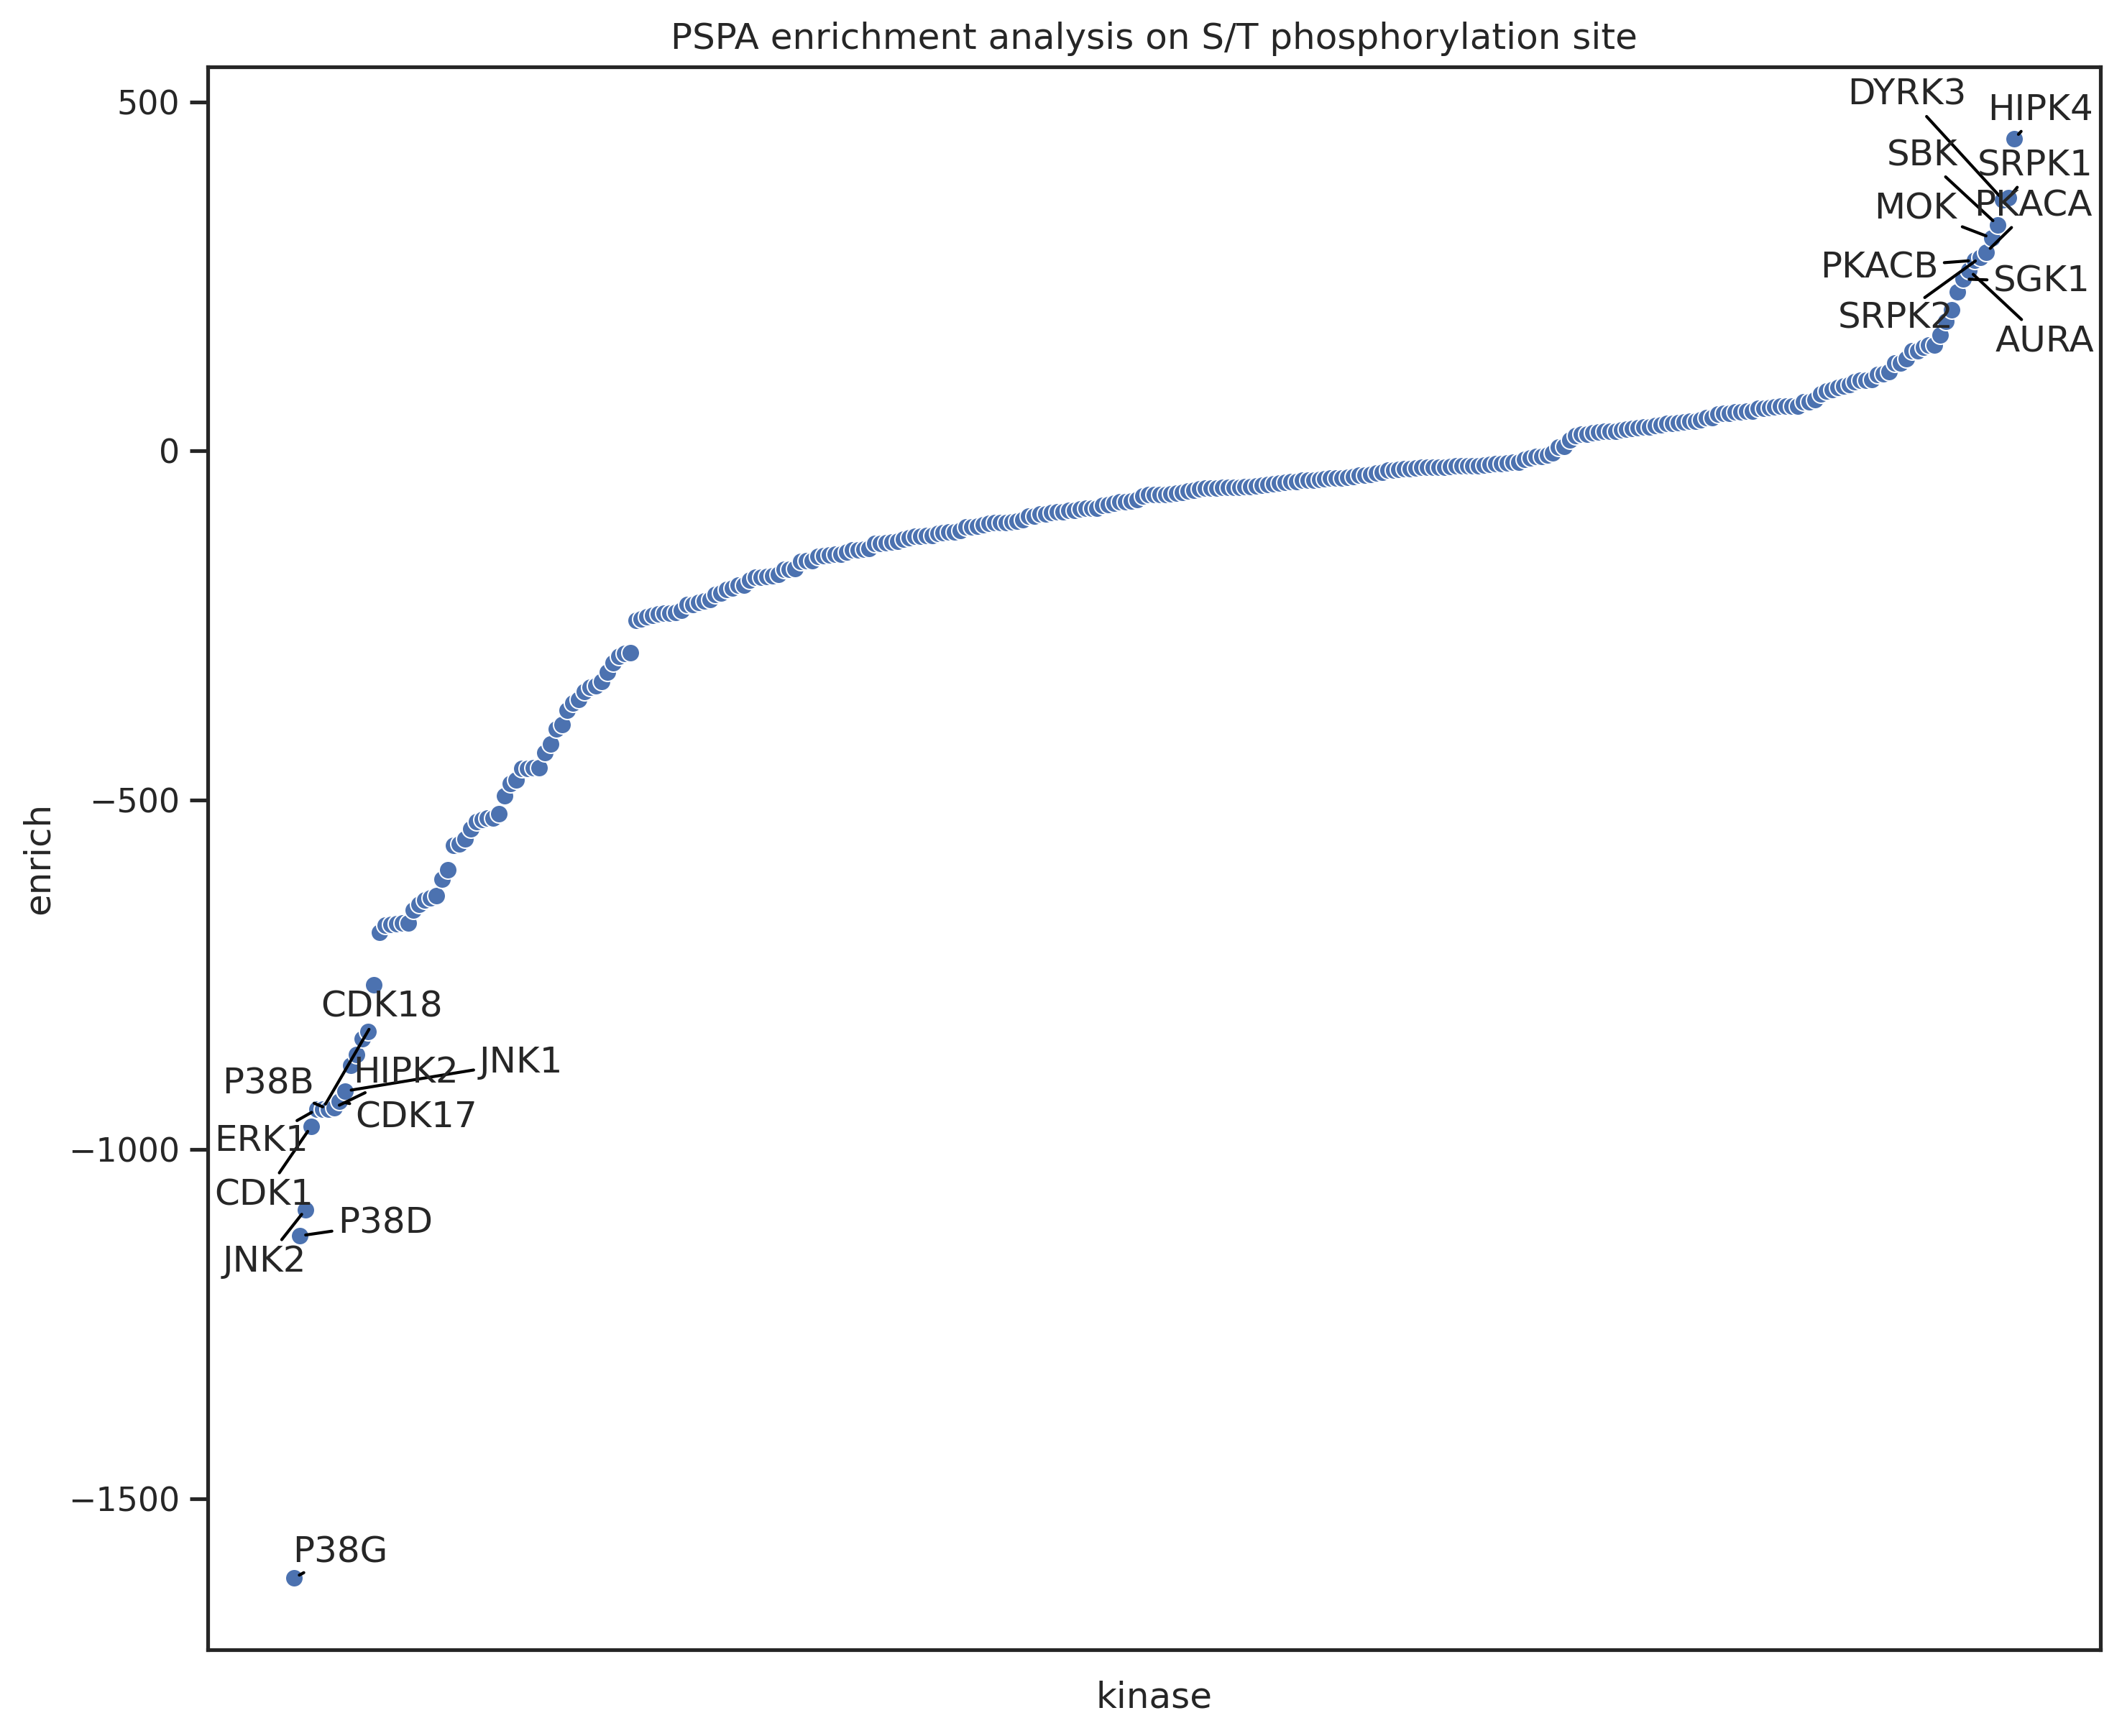

In [ ]:
set_sns()
plot_rank(st_cddm.sort_values('enrich'),'kinase','enrich')
plt.title('CDDM enrichment analysis on S/T phosphorylation site');


plot_rank(st_pspa.sort_values('enrich'),'kinase','enrich')
plt.title('PSPA enrichment analysis on S/T phosphorylation site');

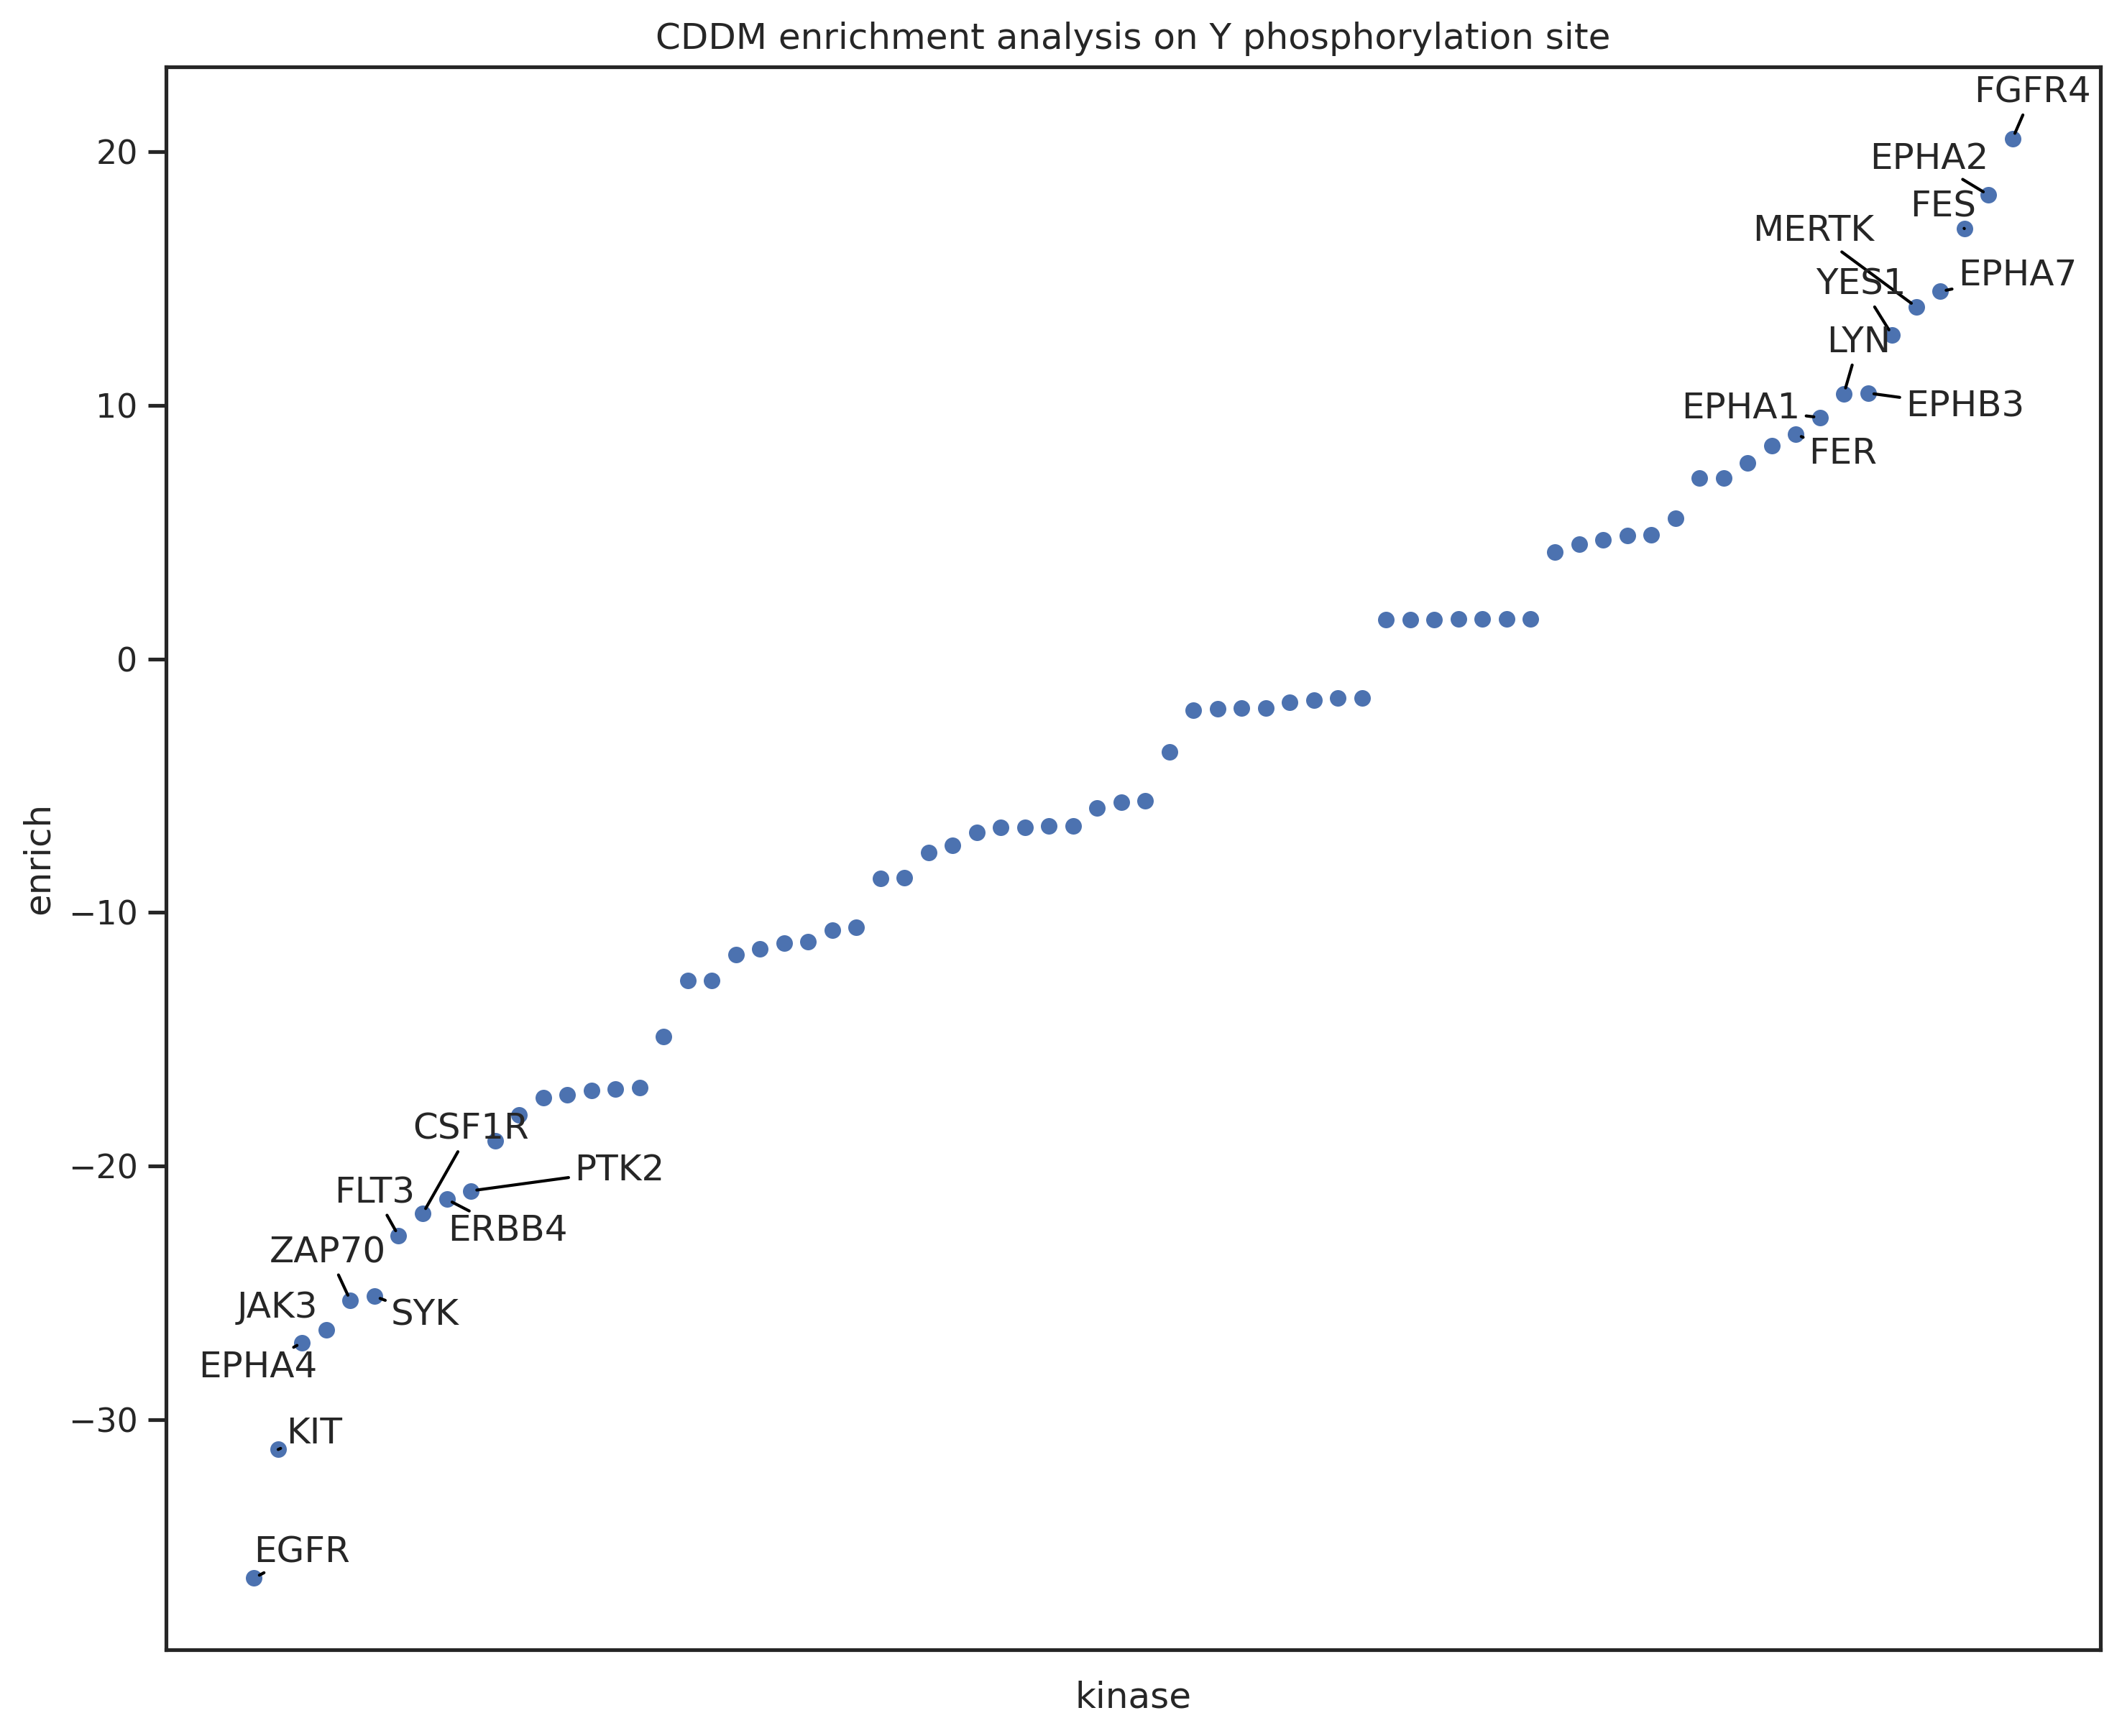

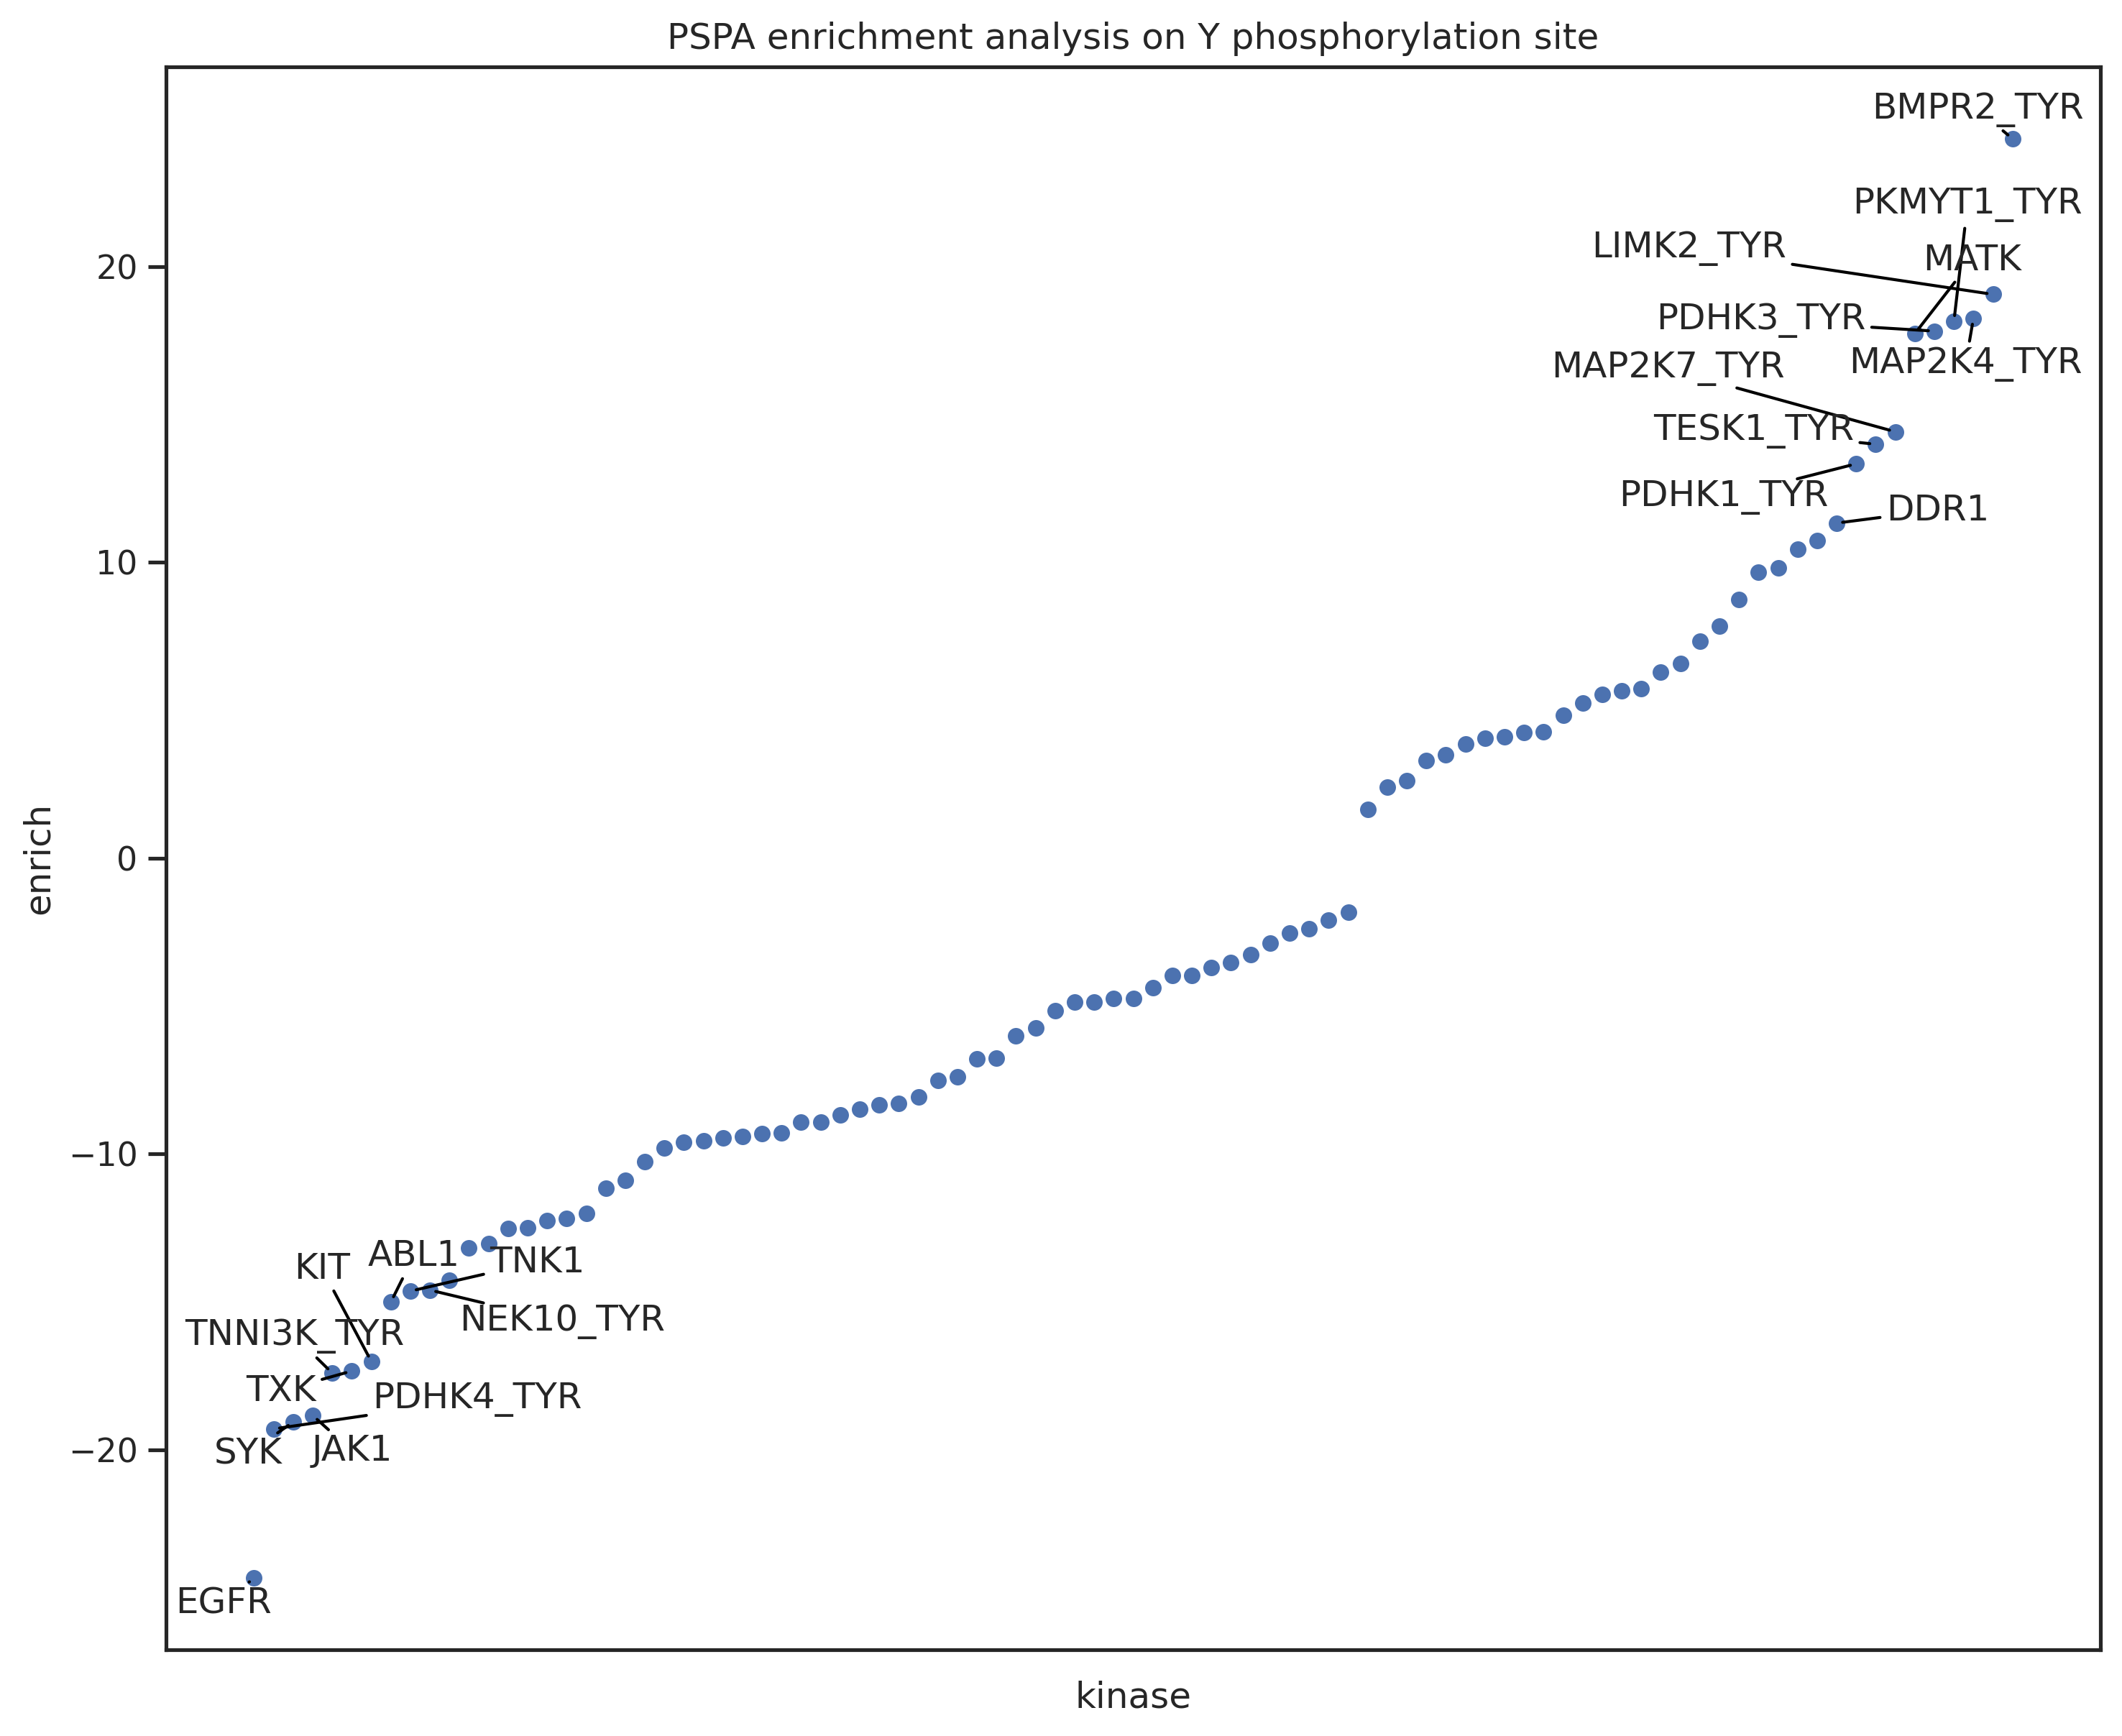

In [ ]:
plot_rank(y_cddm.sort_values('enrich'),'kinase','enrich')
plt.title('CDDM enrichment analysis on Y phosphorylation site');


plot_rank(y_pspa.sort_values('enrich'),'kinase','enrich')
plt.title('PSPA enrichment analysis on Y phosphorylation site');

### Delta

"delta" is the difference between up_weighted_cnt and dn_weighted_cnt

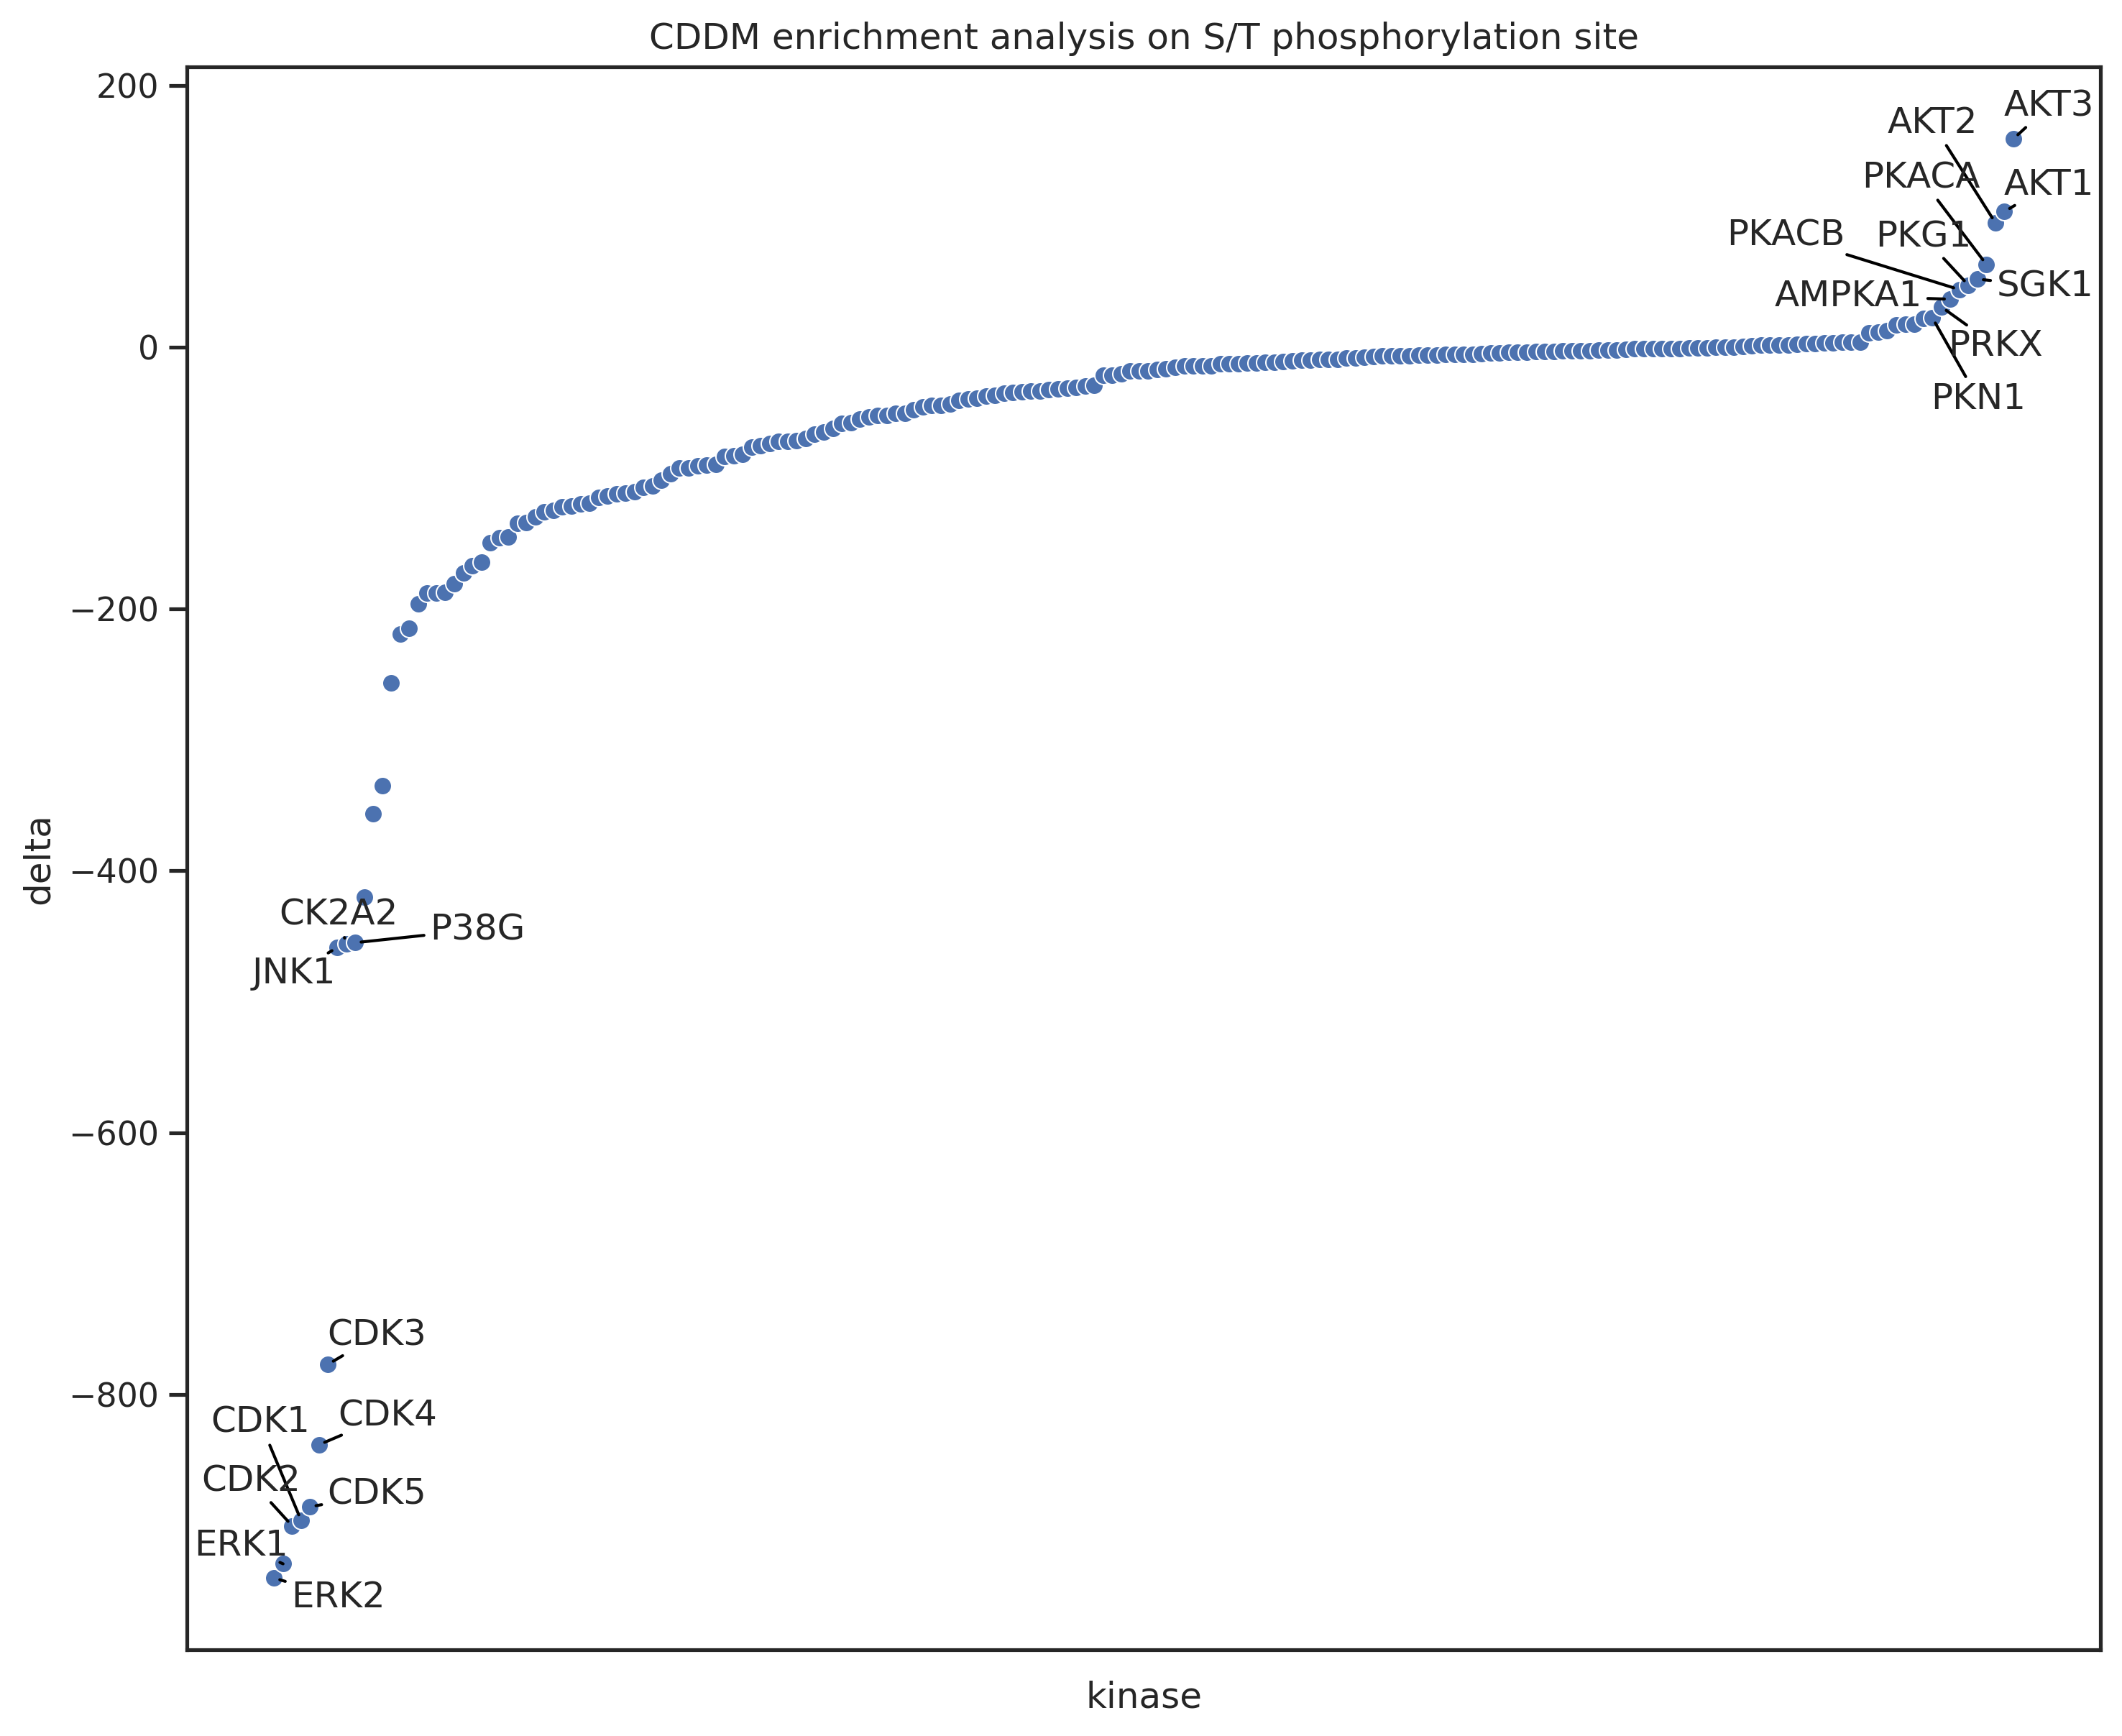

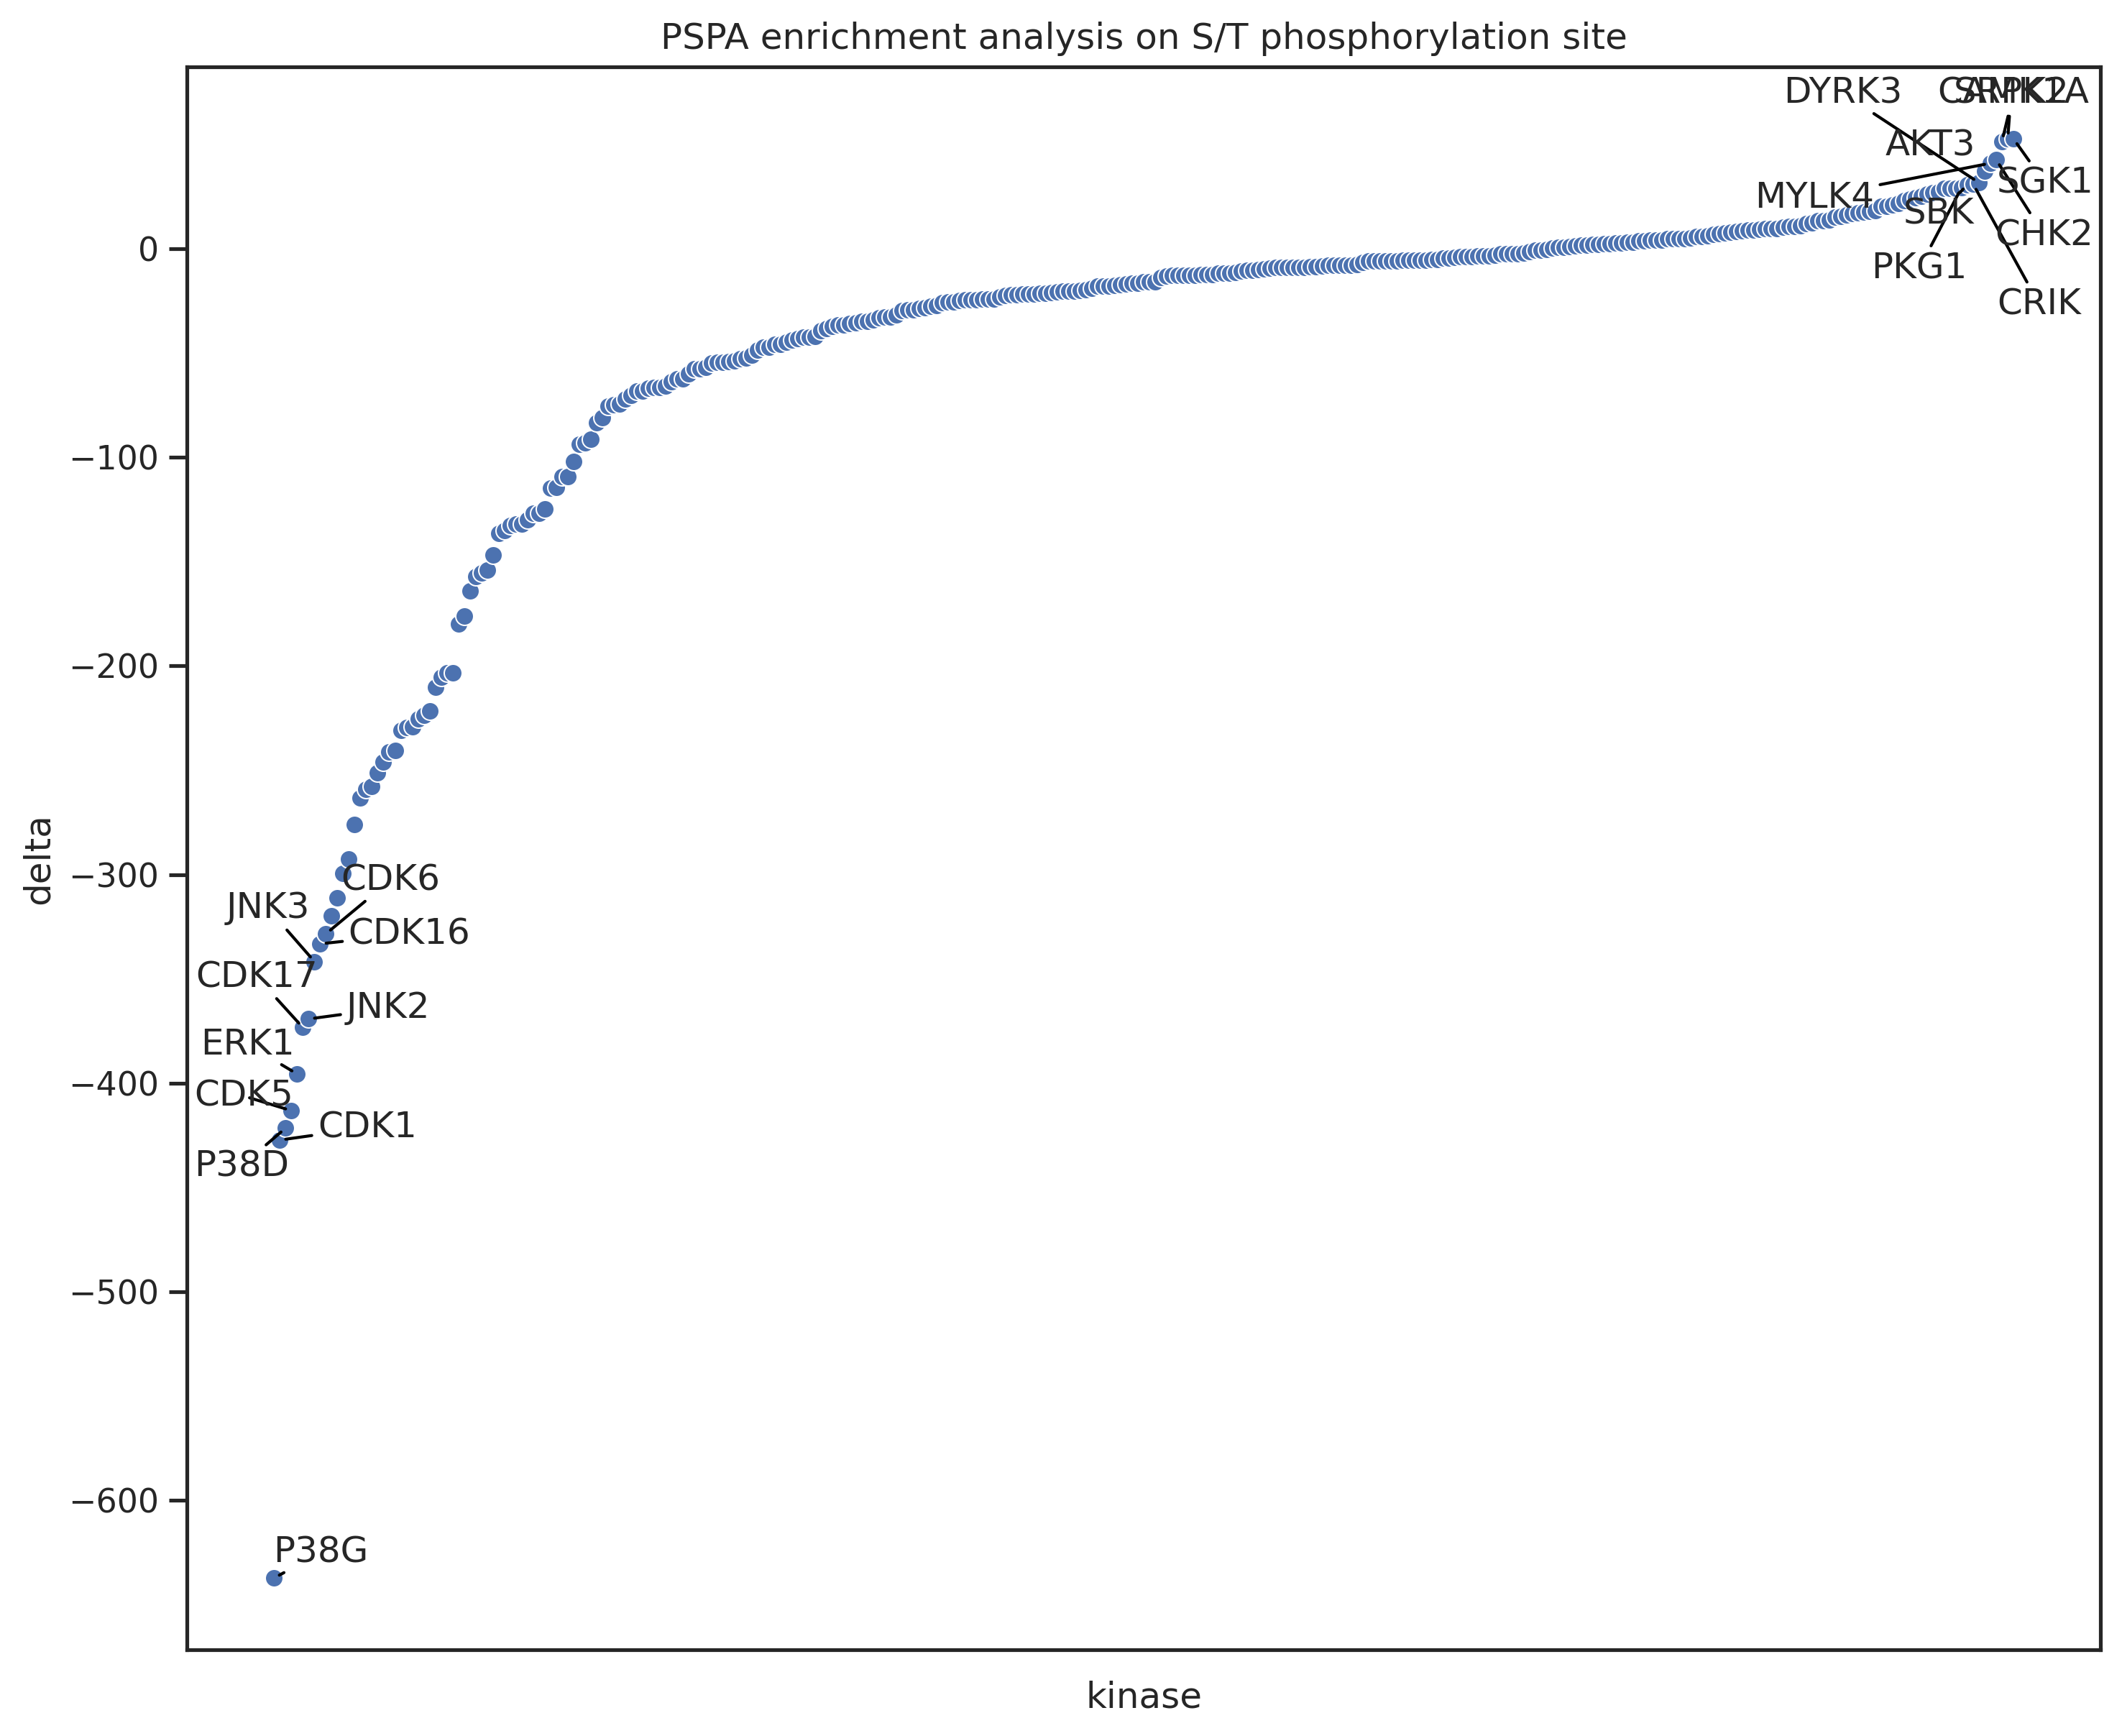

In [ ]:
plot_rank(st_cddm.sort_values('delta'),'kinase','delta')
plt.title('CDDM enrichment analysis on S/T phosphorylation site');


plot_rank(st_pspa.sort_values('delta'),'kinase','delta')
plt.title('PSPA enrichment analysis on S/T phosphorylation site');

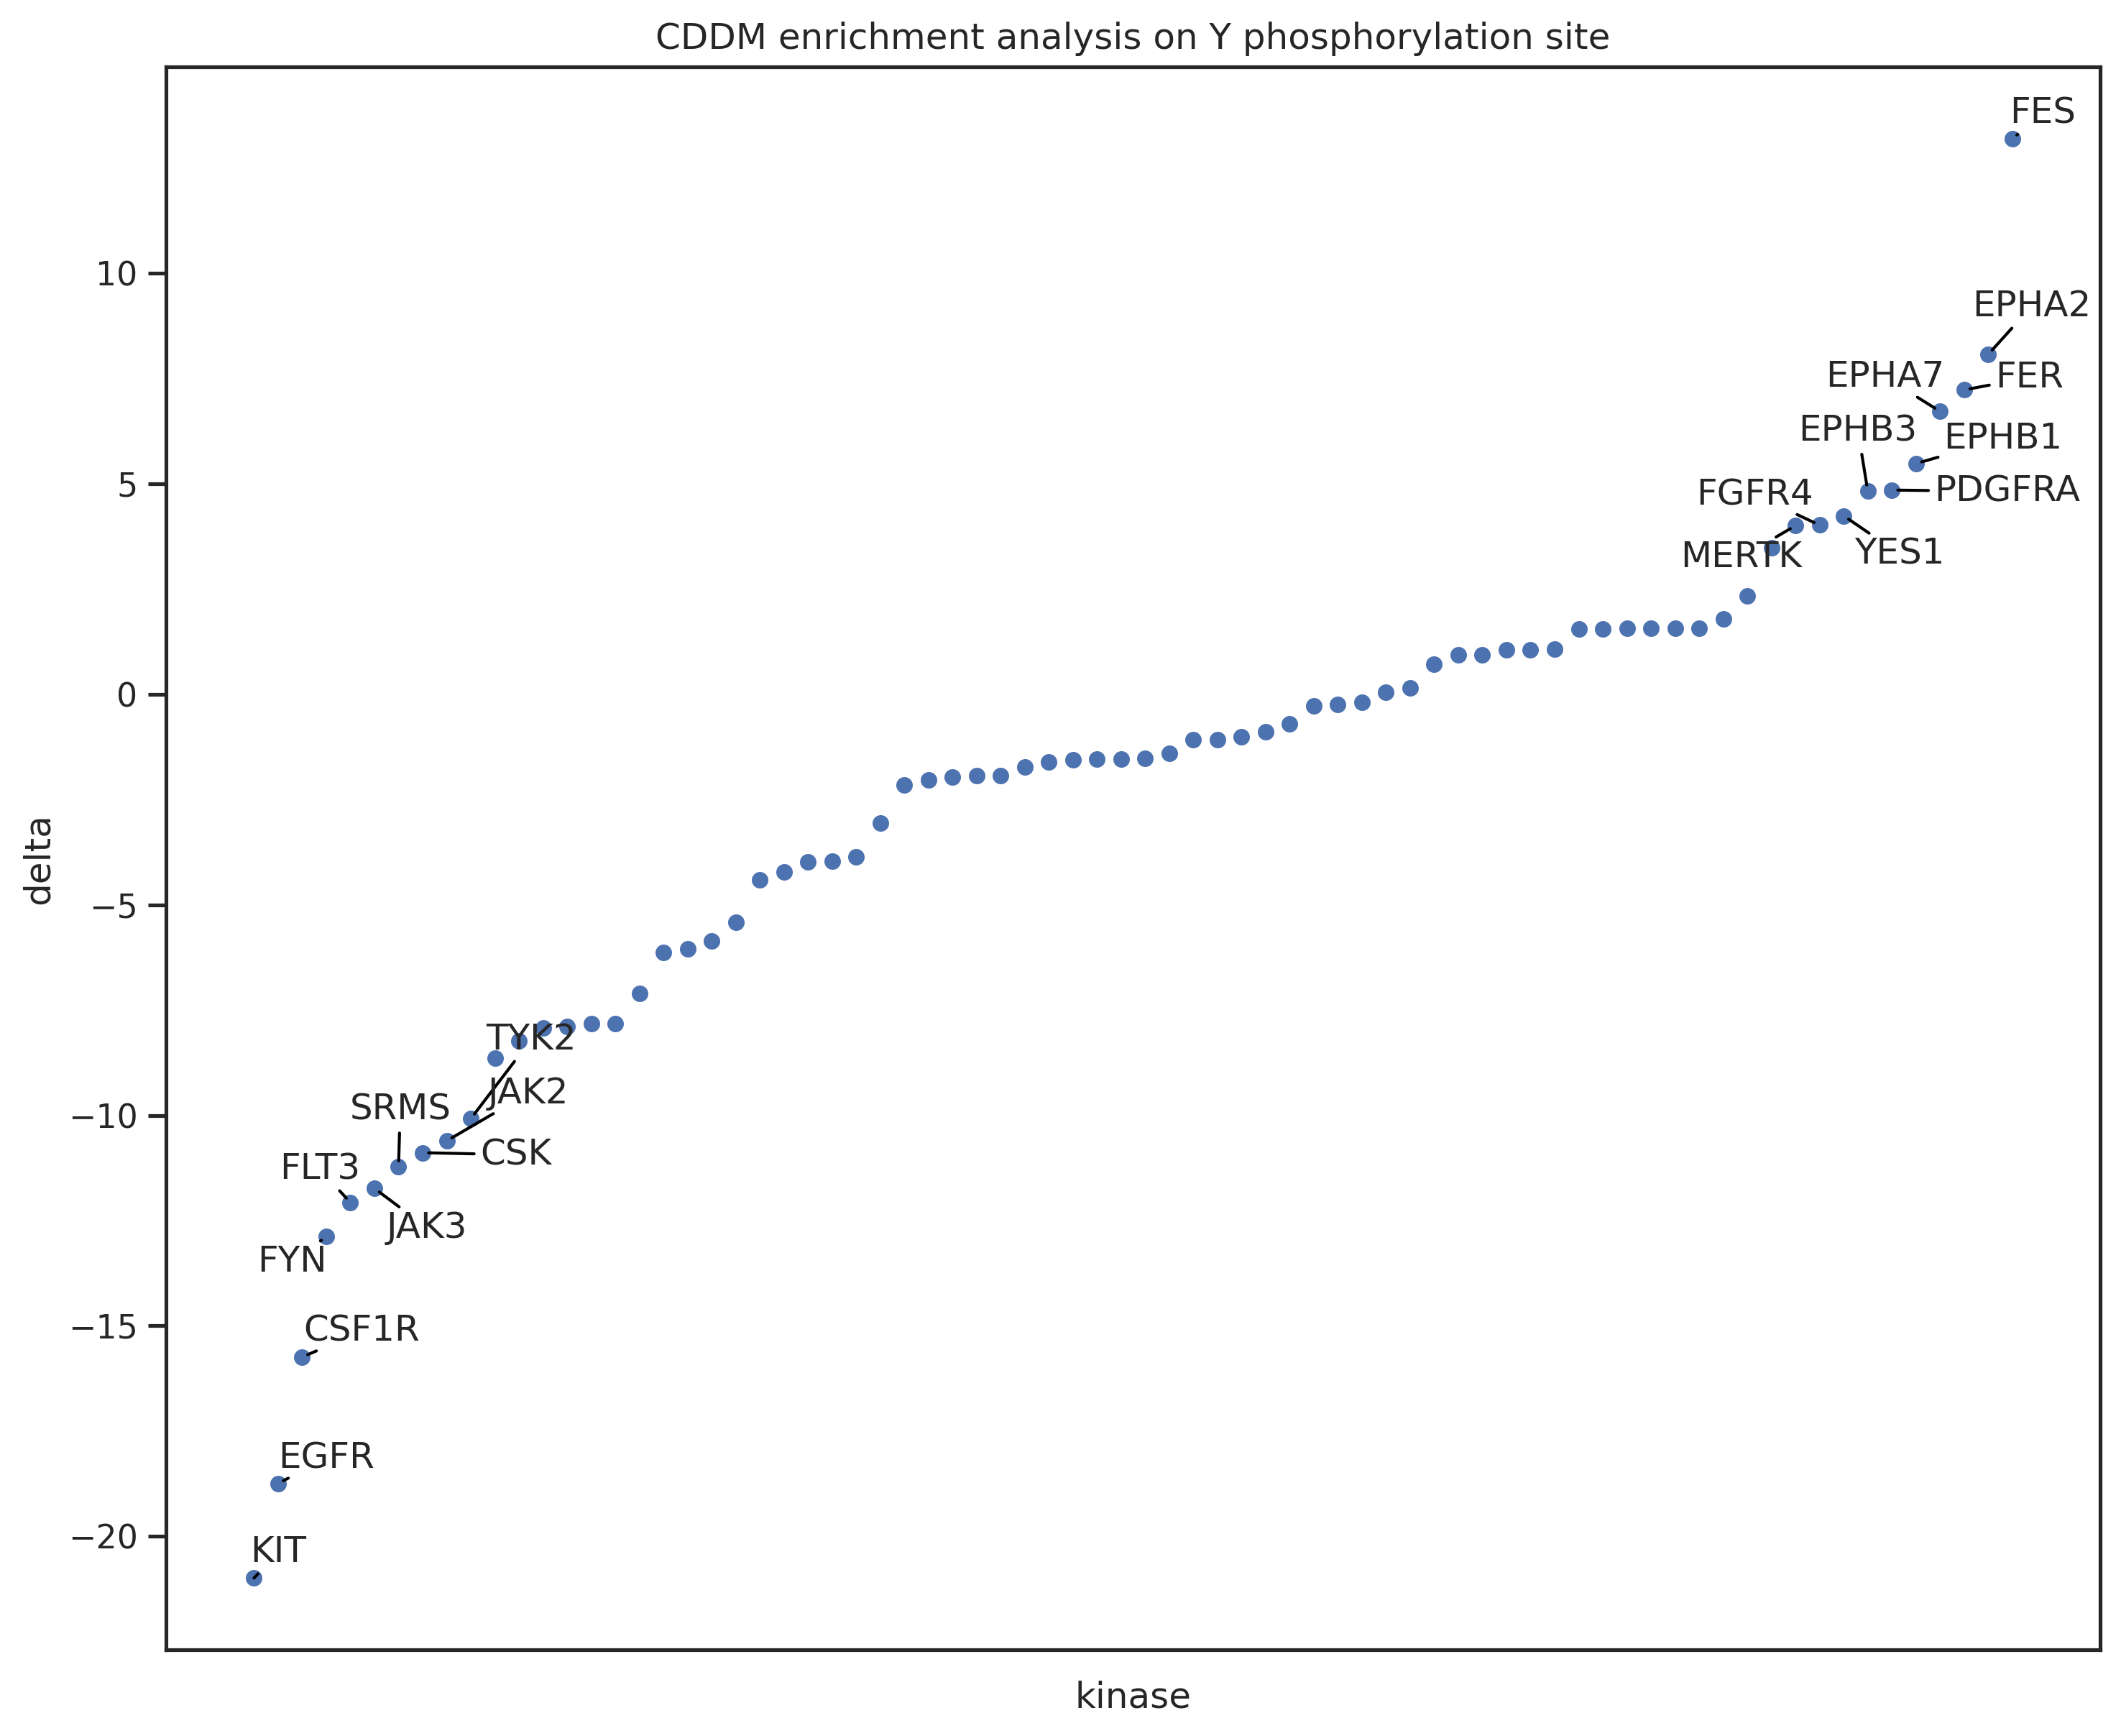

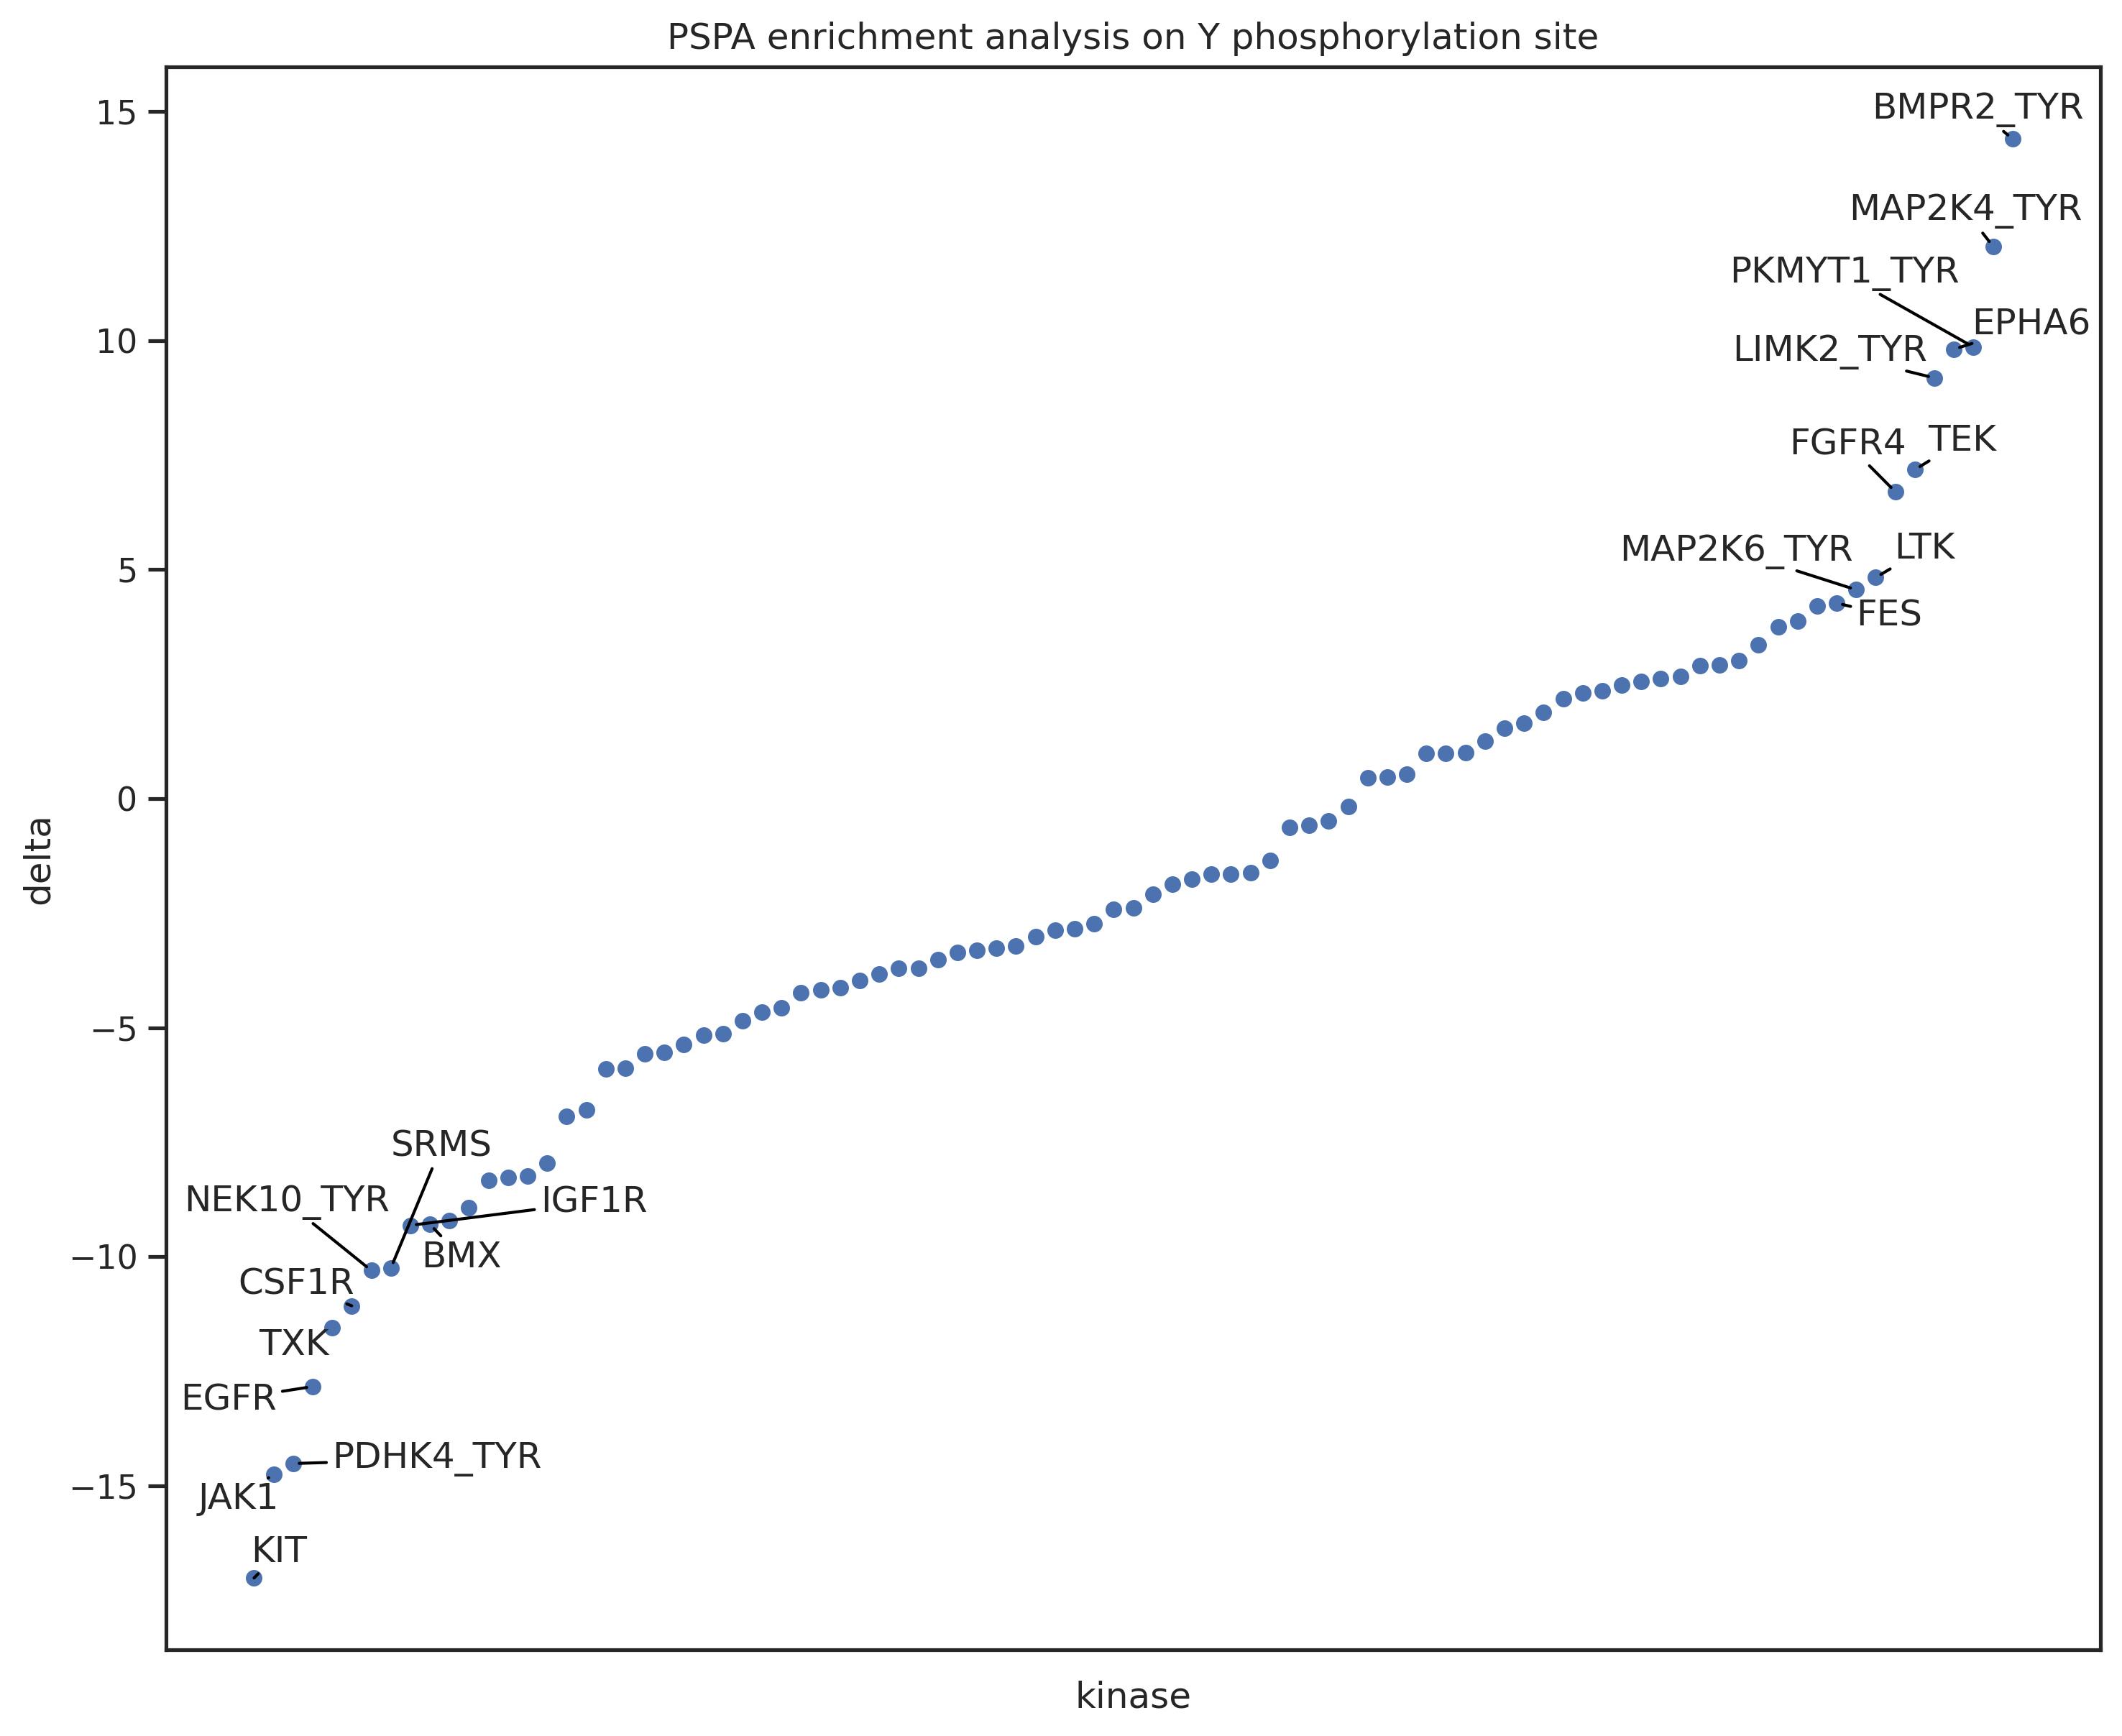

In [ ]:
plot_rank(y_cddm.sort_values('delta'),'kinase','delta')
plt.title('CDDM enrichment analysis on Y phosphorylation site');


plot_rank(y_pspa.sort_values('delta'),'kinase','delta')
plt.title('PSPA enrichment analysis on Y phosphorylation site');

In [ ]:
# st_cddm.sort_values('delta').to_csv('source/Fig5H_EGFRi_st.csv',index=False)

### Visualize in bar graph

In [ ]:
def get_bar_data(df, score_col, top_n = 5):
    
    data = df.sort_values(score_col)[['kinase',score_col]]

    data.columns = ['Kinase','Score']
    
    data = pd.concat([data.head(top_n),data.tail(top_n)]).set_index('Kinase')
    
    return data

In [ ]:
bar_cddm_st = get_bar_data(st_cddm,'delta')
bar_cddm_y = get_bar_data(y_cddm,'delta')

bar_pspa_st = get_bar_data(st_pspa,'delta')
bar_pspa_y = get_bar_data(y_pspa,'delta')

In [ ]:
bar_cddm_st

,Score
Kinase,
ERK2,-940.332234036023237
ERK1,-929.486167367698499
CDK2,-900.387581550277901
CDK1,-896.261673520625436
CDK5,-885.923624522368300
SGK1,52.133654444310082
PKACA,63.276572876477985
AKT2,95.107988726728877
AKT1,103.736559527417057


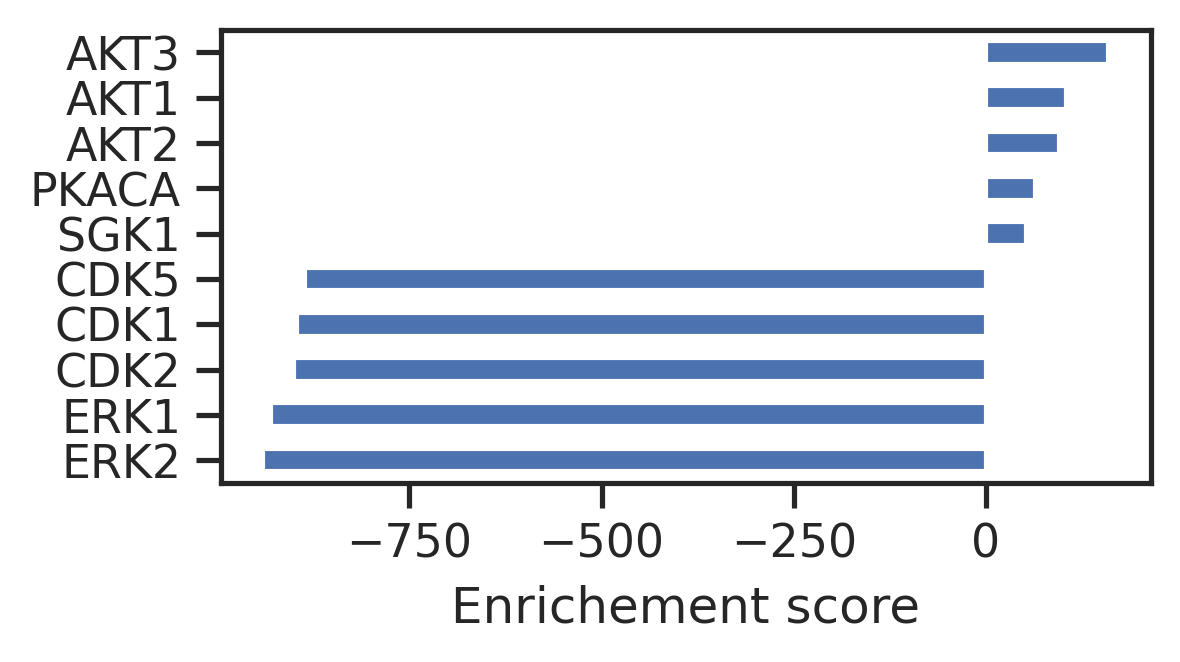

In [ ]:
# CDDM ST site
bar_cddm_st.plot.barh(legend=False,figsize=(4,2))
plt.xlabel('Enrichement score')
plt.ylabel('');

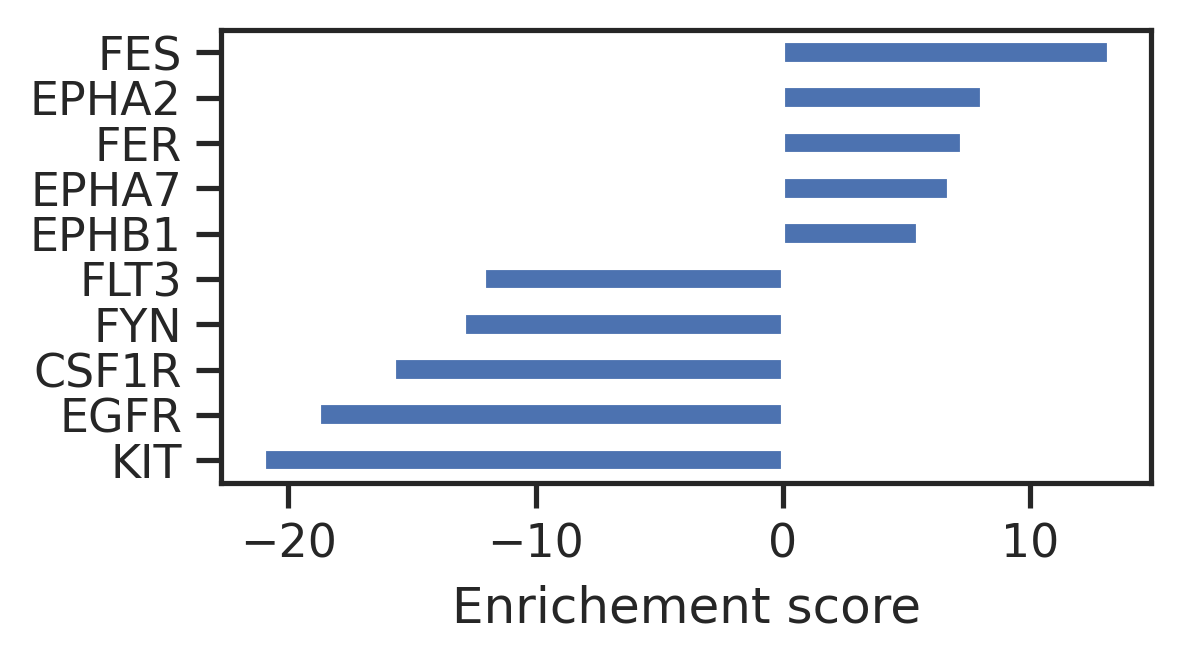

In [ ]:
# CDDM Y site
bar_cddm_y.plot.barh(legend=False,figsize=(4,2))
plt.xlabel('Enrichement score')
plt.ylabel('');

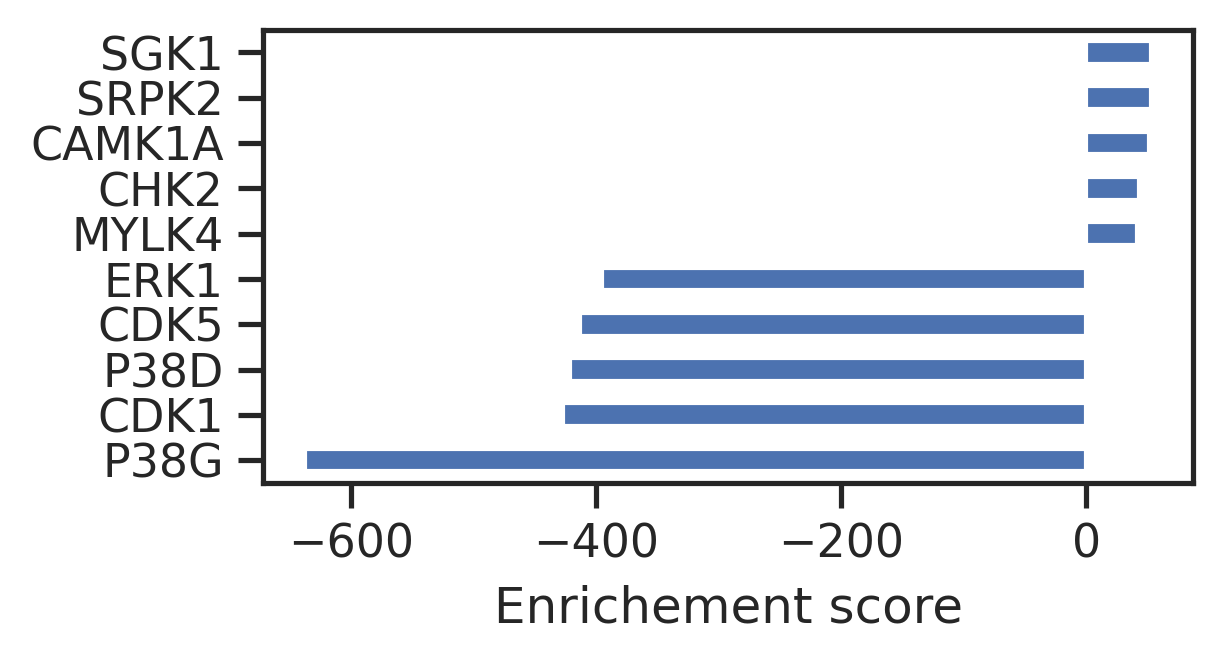

In [ ]:
# PSPA ST site
bar_pspa_st.plot.barh(legend=False,figsize=(4,2))
plt.xlabel('Enrichement score')
plt.ylabel('');

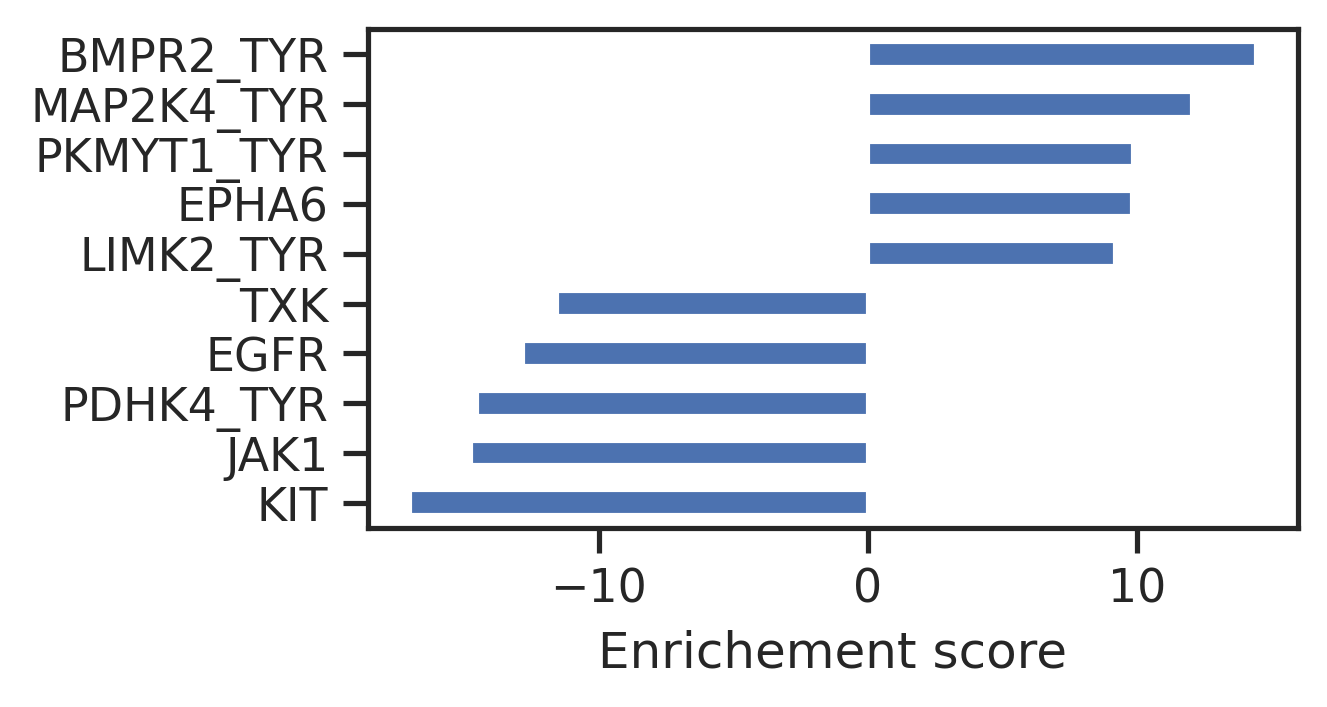

In [ ]:
# PSPA Y site
bar_pspa_y.plot.barh(legend=False,figsize=(4,2.2))
plt.xlabel('Enrichement score')
plt.ylabel('');

## Others, directly inspect important site and its protein

### Important site

Some gene site contains multiple gene name seperated by ";" we will explode them.

In [ ]:
sorted_site = gef.sort_values('signed_logPadj')[['gene_site','signed_logPadj']]

In [ ]:
top_n = 10
sorted_site_top = pd.concat([sorted_site.head(top_n),sorted_site.tail(top_n)])

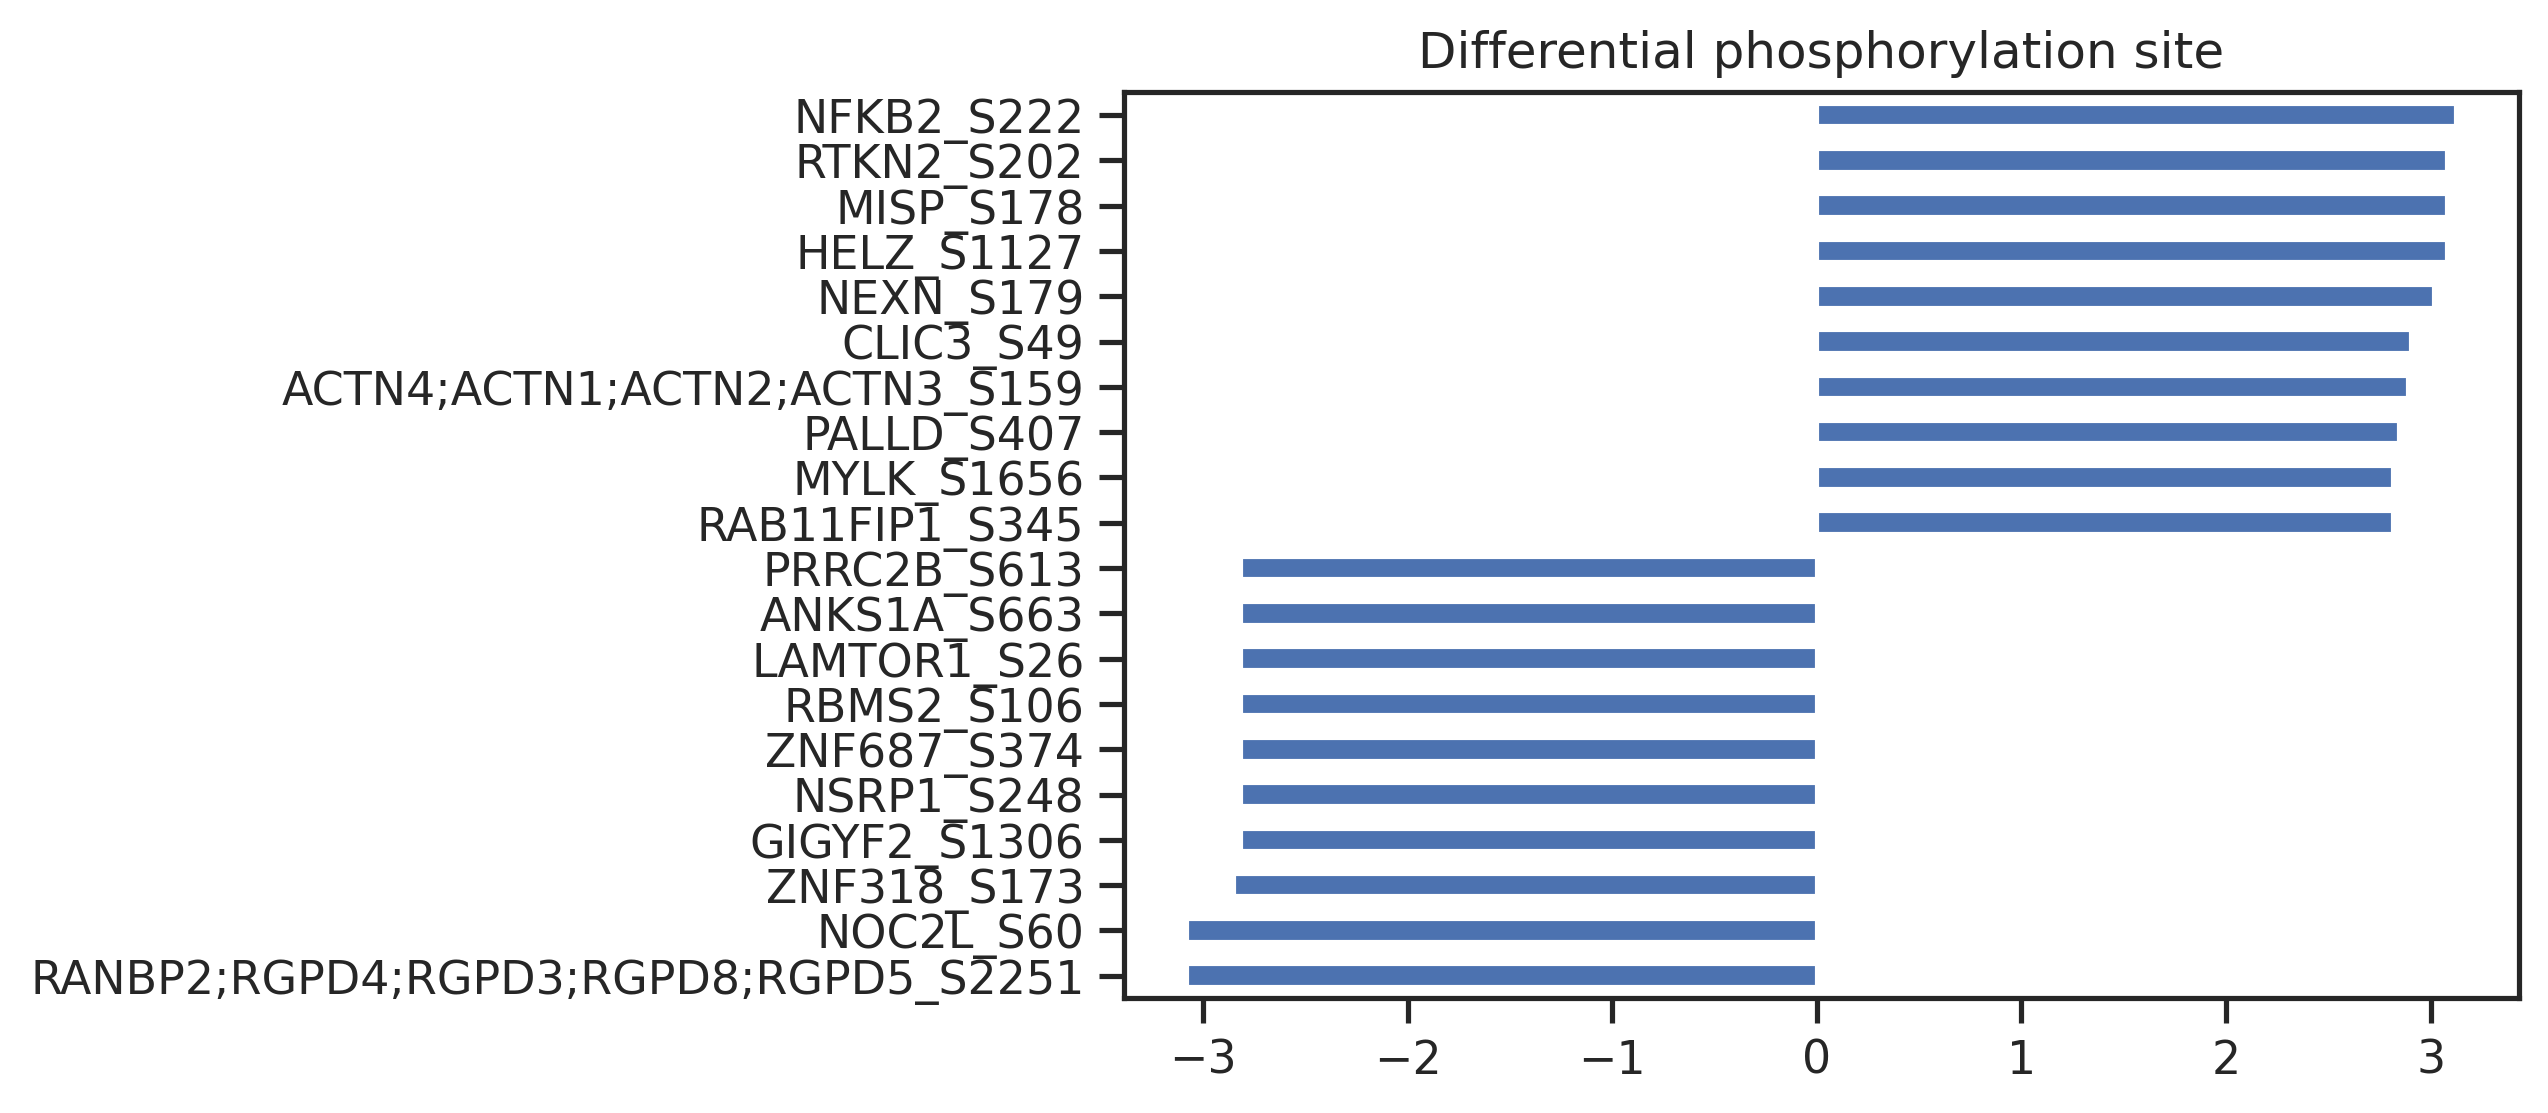

In [ ]:
sorted_site_top.set_index('gene_site').plot.barh(legend=False)
plt.ylabel('')
plt.title('Differential phosphorylation site');

### Gene analysis

In [ ]:
gef['gene'] = gef.gene_site.str.split('_').str[0].str.split(';')

In [ ]:
gef = gef.explode('gene')

For each protein, it has multiple phosphorylation sites with different p value, we will take the most significant p value to represent that protein (gene)

In [ ]:
def get_max(x):
    x = x.dropna().sort_values().values
    return x[0] if abs(x[0])>abs(x[-1]) else x[-1]

In [ ]:
gef_gene = gef.groupby('gene').agg({'signed_logPadj':get_max,'gene_site':'count'}).reset_index()

In [ ]:
sorted_gene = gef_gene.sort_values('signed_logPadj')

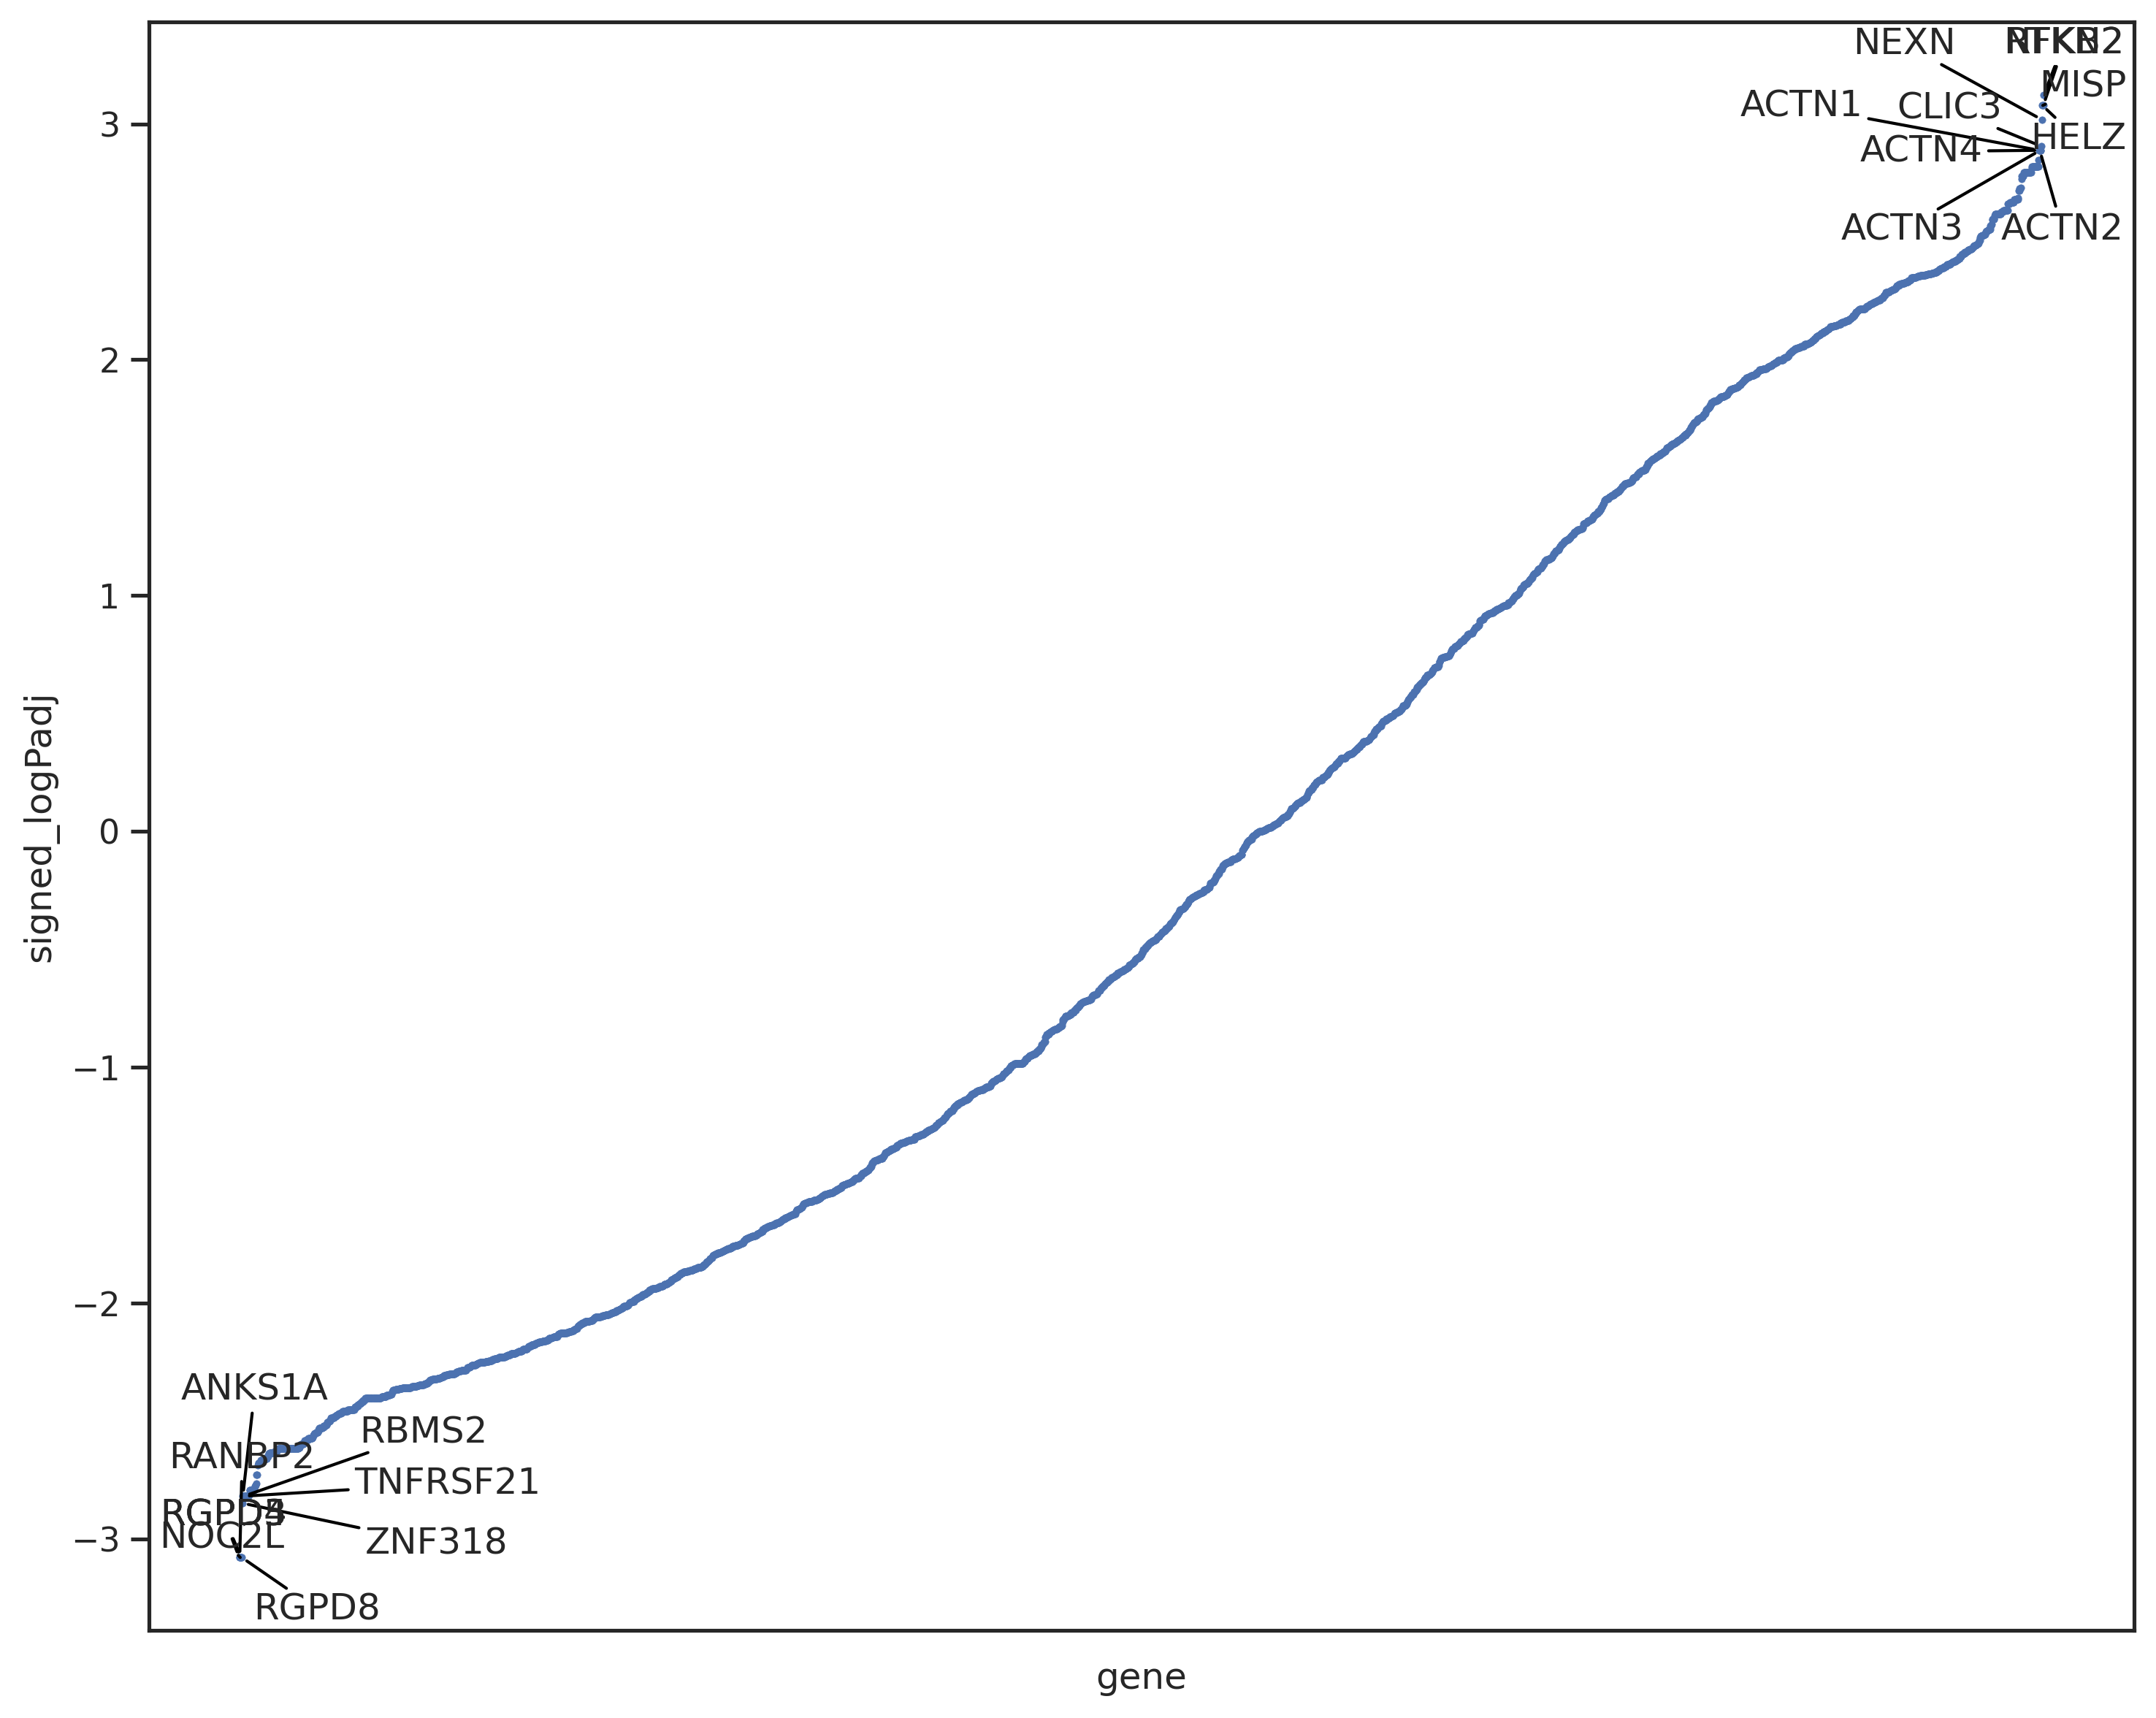

In [ ]:
plot_rank(sorted_gene,x = 'gene',y='signed_logPadj',edgecolor=None,s=5)

### Kinase analysis

In [ ]:
info = Data.get_kinase_info().rename(columns={'ID_HGNC':'gene'}).query('pseudo=="0"')

In [ ]:
gef_kinase = gef_gene.merge(info)

In [ ]:
sorted_kinase = gef_kinase.sort_values('signed_logPadj')

In [ ]:
sorted_kinase

,gene,signed_logPadj,gene_site,kinase,ID_coral,uniprot,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,in_cddm,pseudo,pspa_category_small,pspa_category_big,cddm_big,cddm_small,length,human_uniprot_sequence,kinasecom_domain,nucleus,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
87,MAPK6,-2.633917072951259,4,MAPK6,Erk3,Q16659,CMGC,MAPK,ERK3,ERK3,0,0,0,0,None,None,NaN,NaN,721,MAEKFESLMNIHGFDLGSRYMDLKPLGCGGNGLVFSAVDNDCDKRVAIKKIVLTDPQSVKHALREIKIIRRLDHDNIVKVFEILGPSGSQLTDDVGSLTELNSVYIVQEYMETDLANVLEQGPLLEEHARLFMYQLLRGLKYIHSANVLHRDLKPANLFINTEDLVLKIGDFGLARIMDPHYSHKGHLSEGLVTKWYRSPRLLLSPNNYTKAIDMWAAGCIFAEMLTGKTLFAGAHELEQMQLILESIPVVHEEDRQELLSVIPVYIRNDMTEPHKPLTQLLPGISREALDFLEQILTFSPMDRLTAEEALSHPYMSIYSFPMDEPISSHPFHIEDEVDDILLMDETHSHIYNWERYHDCQFSEHDWPVHNNFDIDEVQLDPRALSDVTDEEEVQVDPRKYLDGDREKYLEDPAFDTNYSTEPCWQYSDHHENKYCDLECSHTCNYKTRSSSYLDNLVWRESEVNHYYEPKLIIDLSNWKEQSKEKSDKKGKSKCERNGLVKAQIALEEASQQLAGKEREKNQGFDFDSFIAGTIQLSSQHEPTDVVDKLNDLNSSVSQLELKSLISKSVSQEKQEKGMANLAQLEALYQSSWDSQ...,YMDLKPLGCGGNGLVFSAVDNDCDKRVAIKKIVLTDPQSVKHALREIKIIRRLDHDNIVKVFEILGPSGSQLTDDVGSLTELNSVYIVQEYMETDLANVLEQGPLLEEHARLFMYQLLRGLKYIHSANVLHRDLKPANLFINTEDLVLKIGDFGLARIMDPHYSHKGHLSEGLVTKWYRSPRLLLSPNNYTKAIDMWAAGCIFAEMLTGKTLFAGAHELEQMQLILESIPVVHEEDRQELLSVIPVYIRNDMTEPHKPLTQLLPGISREALDFLEQILTFSPMDRLTAEEALSHPYM,5.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
83,MAPK1,-2.633917072951259,3,ERK2,Erk2,P28482,CMGC,MAPK,ERK1,ERK1,1,0,1,0,MAPK,pro-directed,3.0,16.0,360,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQPGYRS,YTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYL,1.0,6.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
86,MAPK3,-2.616513886592222,2,ERK1,Erk1,P27361,CMGC,MAPK,ERK1,ERK1,1,0,1,0,MAPK,pro-directed,3.0,16.0,379,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQYIGEGAYGMVSSAYDHVRKTRVAIKKISPFEHQTYCQRTLREIQILLRFRHENVIGIRDILRASTLEAMRDVYIVQDLMETDLYKLLKSQQLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLINTTCDLKICDFGLARIADPEHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINMKARNYLQSLPSKTKVAWAKLFPKSDSKALDLLDRMLTFNPNKRITVEEALAHPYLEQYYDPTDEPVAEEPFTFAMELDDLPKERLKELIFQETARFQPGVLEAP,YTQLQYIGEGAYGMVSSAYDHVRKTRVAIKKISPFEHQTYCQRTLREIQILLRFRHENVIGIRDILRASTLEAMRDVYIVQDLMETDLYKLLKSQQLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLINTTCDLKICDFGLARIADPEHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINMKARNYLQSLPSKTKVAWAKLFPKSDSKALDLLDRMLTFNPNKRITVEEALAHPYL,2.0,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
52,EPHA2,-2.616513886592222,11,EPHA2,EphA2,P29317,TK,Eph,None,Eph,0,1,1,0,Ephrin receptors,Ephrin receptors,1.0,2.0,976,MELQAARACFALLWGCALAAAAAAQGKEVVLLDFAAAGGELGWLTHPYGKGWDLMQNIMNDMPIYMYSVCNVMSGDQDNWLRTNWVYRGEAERIFIELKFTVRDCNSFPGGASSCKETFNLYYAESDLDYGTNFQKRLFTKIDTIAPDEITVSSDFEARHVKLNVEERSVGPLTRKGFYLAFQDIGACVALLSVRVYYKKCPELLQGLAHFPETIAGSDAPSLATVAGTCVDHAVVPPGGEEPRMHCAVDGEWLVPIGQCLCQAGYEKVEDACQACSPGFFKFEASESPCLECPEHTLPSPEGATSCECEEGFFRAPQDPASMPCTRPPSAPHYLTAVGMGAKVELRWTPPQDSGGREDIVYSVTCEQCWPESGECGPCEASVRYSEPPHGLTRTSVTVSDLEPHMNYTFTVEARNGVSGLVTSRSFRTASVSINQTEPPKVRLEGRSTTSLSVSWSIPPPQQSRVWKYEVTYRKKGDSNSYNVRRTEGFSVTLDDLAPDTTYLVQVQALTQEGQGAGSKVHEFQTLSPEGSGNLAVIGGVAVGVVLLLVLAGVGFFIHRRRKNQRARQSPEDVYFSKSEQLKPLKTYVDPHTYED...,VTRQKVIGAGEFGEVYKGMLKTSSGKKEVPVAIKTLKAGYTEKQRVDFLGEAGIMGQFSHHNIIRLEGVISKYKPMMIITEYMENGALDKFLREKDGEFSVLQLVGMLRGIAAGMKYLANMNYVHRDLAARNILVNSNLVCKVSDFGLSRVLEDDPEATYTTSGGKIPIRWTAPEAISYRKFTSASDVWSFGIVMWEVMTYGERPYWELSNHEVMKAINDGFRLPTPM

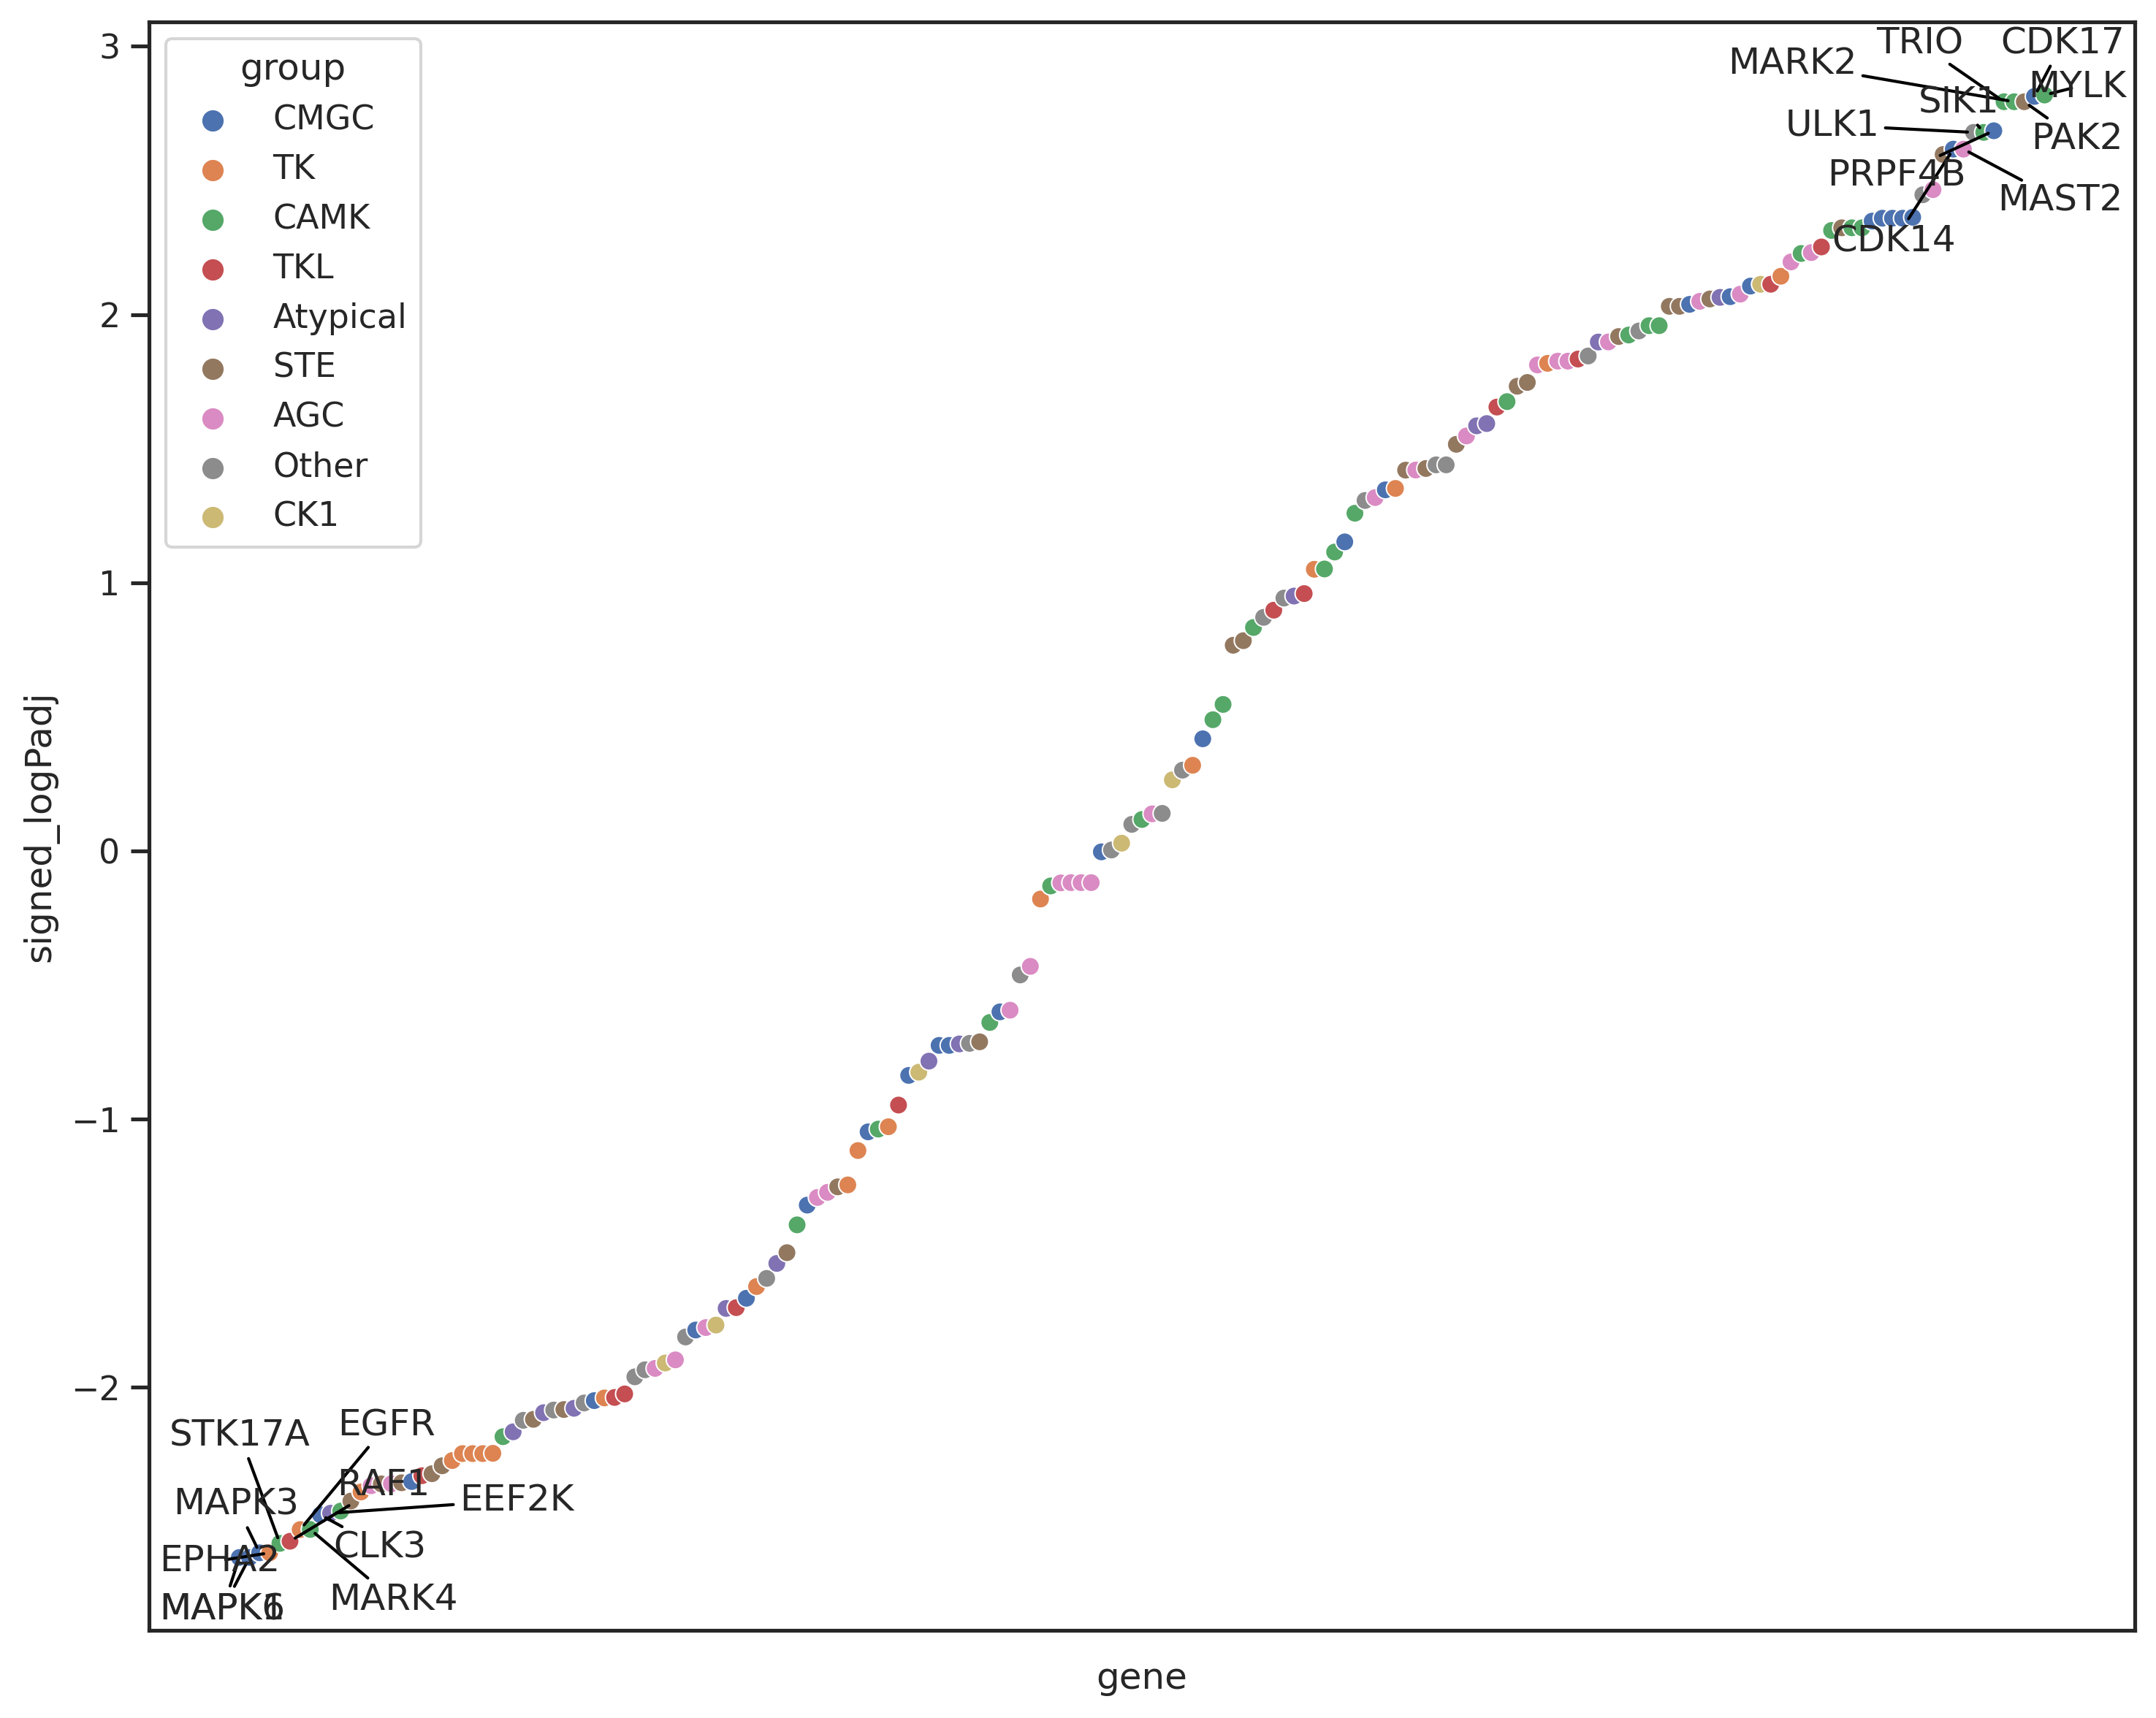

In [ ]:
plot_rank(sorted_kinase,x = 'gene',y='signed_logPadj',hue='group')